In [1]:
import pennylane as qml

import tensorflow as tf
import sklearn.datasets
from sklearn.datasets import fetch_openml

import numpy as np
import pandas as pd
from datetime import datetime

from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import plot_model
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from pprint import pprint
from pennylane.operation import Tensor


tf.keras.backend.set_floatx('float64')

## Load MNIST Dataset

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)
print(x_train[..., np.newaxis].shape)

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

(60000, 28, 28)
(60000, 28, 28, 1)
Number of original training examples: 60000
Number of original test examples: 10000


## Preprocess Data

In [3]:
digits_to_be_filtered = [3, 6]
resize_dims = (9,9)

In [4]:
def preprocess_data(x_train, x_test):

    # Rescale the images from [0,255] to the [0.0,1.0] range.
    x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0  # add colour dimension

    return x_train, x_test

In [5]:
x_train_preprocessed, x_test_preprocessed = preprocess_data(x_train, x_test)
x_train_preprocessed.shape

(60000, 28, 28, 1)

In [6]:
def filter_digits(x, y, digits=[3, 6]):
    """
    Filter the dataset to only keep the specified digit classes.
    Args:
        x: input images
        y: corresponding labels
        digits: the classes we want to keep
    Returns:
        x_filtered, y_filtered: filtered images and labels
    """
    keep = np.where(np.isin(y, digits))
    x_filtered, y_filtered = x[keep], y[keep]
    
    # Change labels to start from 0 and make them consecutive
    y_filtered = np.array(y_filtered)
    label_mapping = {}
    for i, digit in enumerate(digits):
        y_filtered[y_filtered==digit] = i
        label_mapping[i] = digit
    
    
    return x_filtered, y_filtered, label_mapping
        

In [7]:
x_train_filtered, y_train_filtered, label_mapping = filter_digits(x_train_preprocessed, y_train, digits=digits_to_be_filtered)
x_test_filtered, y_test_filtered, label_mapping = filter_digits(x_test_preprocessed, y_test, digits=digits_to_be_filtered)

print("Number of filtered training examples:", len(x_train_filtered))
print("Number of filtered test examples:", len(x_test_filtered))
print(pd.Series(y_train_filtered).value_counts().sort_index())
print(label_mapping)

Number of filtered training examples: 12049
Number of filtered test examples: 1968
0    6131
1    5918
dtype: int64
{0: 3, 1: 6}


In [8]:
def plot_MNIST_greyscale(x_train,y_train,label_mapping,image_index=0, save_img=False):

    if len(x_train.shape) == 2:
        plt.imshow(x_train[image_index,:].reshape((1,-1)), vmin=0, vmax=1, cmap='Greys')  # vmin=0, vmax=1,
        dim_1 = x_train.shape[1]
        dim_2 = 1
    elif len(x_train.shape) == 3:
        plt.imshow(x_train[image_index, :, :], cmap='Greys')
        dim_1 = x_train.shape[1]
        dim_2 = x_train.shape[2]  
    elif len(x_train.shape) == 4:
        plt.imshow(x_train[image_index, :, :, 0], cmap='Greys')
        dim_1 = x_train.shape[1]
        dim_2 = x_train.shape[2]
        
    ax = plt.gca()
    ax.set_xticks([])
    ax.set_yticks([])
    print(x_train.shape)
    plt.title("{}x{} MNIST image of {}".format(dim_1, dim_2, label_mapping[y_train[image_index]]), fontsize=20)
    if save_img:
        plt.savefig('MNIST_{}x{}_{}.pdf'.format(dim_1, dim_2, label_mapping[y_train[image_index]]), bbox_inches='tight', pad_inches=0)
    plt.show()

(12049, 28, 28, 1)


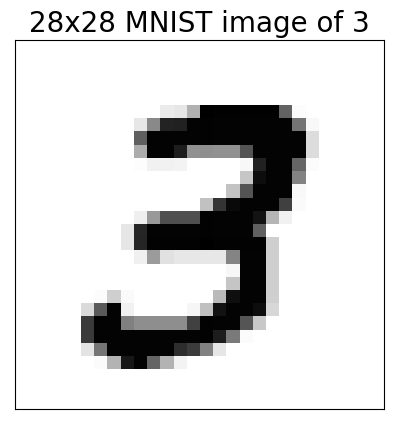

In [9]:
plot_MNIST_greyscale(x_train_filtered,y_train_filtered,label_mapping,image_index=0)

In [10]:
def resize_image(image, target_size=(3,3)):
    resized_image = tf.image.resize(image, target_size).numpy()

    return resized_image

In [11]:
print(x_train_filtered.shape)
x_train_resized = resize_image(x_train_filtered, target_size=resize_dims)
x_test_resized = resize_image(x_test_filtered, target_size=resize_dims)
x_train_resized.shape

(12049, 28, 28, 1)


(12049, 9, 9, 1)

(12049, 9, 9, 1)


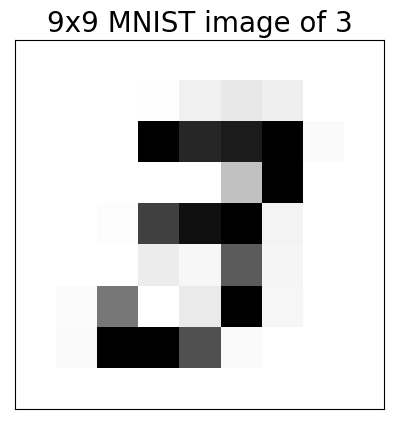

In [12]:
plot_MNIST_greyscale(x_train_resized,y_train_filtered,label_mapping,image_index=0)

In [13]:
# flatten images from shape (1000,28,28,1) to shape (1000,1,784) 

def flatten_images(images):
    num_images, height, width, channels = images.shape
    flattened_images = np.reshape(images, (num_images, height * width * channels))
    return flattened_images




# def flatten_images(images):
#     print(images.shape)
#     flattened_images = images.reshape((-1, images.shape[1]*images.shape[2]))
#     return flattened_images

In [14]:
print(x_train_resized.shape)
x_train_flattened = flatten_images(x_train_resized)
print(x_train_flattened.shape)
x_train_flattened[0]

(12049, 9, 9, 1)
(12049, 81)


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00965871, 0.11764728, 0.1653598 ,
       0.12806845, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.9882353 , 0.8594772 , 0.89546114, 0.9882353 ,
       0.03856194, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.35282016, 0.9882353 , 0.        ,
       0.        , 0.        , 0.        , 0.0245098 , 0.7910676 ,
       0.93235296, 0.9882353 , 0.09520682, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.14547336, 0.06710247,
       0.702711  , 0.08060972, 0.        , 0.        , 0.        ,
       0.02879458, 0.6000127 , 0.        , 0.15577365, 0.983999  ,
       0.07352912, 0.        , 0.        , 0.        , 0.04934643,
       0.9882353 , 0.9882353 , 0.74182993, 0.04208412, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [15]:
def slice_image(image, slice_axis='horizontal', centre_slice=True, central_fraction=0.1):
    """
    Slice images along the specified axis by taking a central fraction of pixels.

    Args:
    data (numpy.ndarray): The input images with shape (num_images, height, width).
    slice_axis (str): Either 'horizontal' or 'vertical' for row or column slicing, respectively.
    centre_slice (bool): Whether to take the central slice or not.
    central_fraction (float): The fraction of central pixels to be taken (e.g., 0.5 for half of the pixels).

    Returns:
    numpy.ndarray: The sliced images.
    """
    assert 0 < central_fraction <= 1, "central_fraction must be in (0, 1]"
    assert image.ndim == 4, "Input data must have 3 dimensions: (num_images, height, width, channels)"
    assert slice_axis in ['horizontal', 'vertical'], "slice_axis must be 'horizontal' or 'vertical'"

    num_images, height, width, channels = image.shape

    if slice_axis == 'horizontal':
        if centre_slice:
            print(height//2)
            sliced_data = image[:, height//2, :, :].reshape((-1,height))
        else:
            start_row = int((1 - central_fraction) * height / 2)
            end_row = height - start_row
            sliced_data = image[:, start_row:end_row, :, :].reshape((-1,height))
    else:  # slice_axis == 'vertical'
        if centre_slice:
            print(width//2)
            sliced_data = image[:, width//2, :, :].reshape((-1,width))
        else:
            start_col = int((1 - central_fraction) * width / 2)
            end_col = width - start_col
            sliced_data = image[:, :, start_col:end_col, :].reshape((-1,width))

    return sliced_data

In [16]:
start_row = int((1 - 1/9) * 9 / 2)
end_row = 9 - start_row
print(start_row, end_row)

4 5


In [17]:
print(x_train_resized.shape)
x_train_sliced = slice_image(x_train_resized, slice_axis='horizontal', centre_slice=True, central_fraction=1/x_train_resized.shape[1])
x_test_sliced = slice_image(x_test_resized, slice_axis='horizontal', centre_slice=True, central_fraction=1/x_train_resized.shape[1])
x_train_sliced.shape

(12049, 9, 9, 1)
4
4


(12049, 9)

(12049, 9)


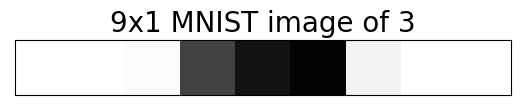

In [18]:
plot_MNIST_greyscale(x_train_sliced,y_train_filtered,label_mapping,image_index=0)

In [19]:
x_train_sliced[0]

array([0.        , 0.        , 0.0245098 , 0.7910676 , 0.93235296,
       0.9882353 , 0.09520682, 0.        , 0.        ], dtype=float32)

In [20]:
x_train_final = x_train_flattened
y_train_final = y_train_filtered
x_test_final = x_train_flattened
y_test_final = y_test_filtered
x_train_final.shape

(12049, 81)

## Build Quantum ML Model

In [21]:
n_qubits = 8
n_layers = 1

In [22]:
import math
def frqi_encoding_single_image(image_vector):
    frqi_encoded_image = []
    for i in range(image_vector.shape[0]):
        frqi_encoded_image.append((1/np.sqrt(image_vector.shape[0]))*(math.cos((math.pi*image_vector[i])/2)))
        frqi_encoded_image.append((1/np.sqrt(image_vector.shape[0]))*(math.sin((math.pi*image_vector[i])/2)))
    return frqi_encoded_image

def frqi_encoding_all_images(images):
    frqi_encoded_images = []
    for i in range(images.shape[0]):
        frqi_encoded_image = frqi_encoding_single_image(image_vector=images[i])
        frqi_encoded_images.append(frqi_encoded_image)
    return np.array(frqi_encoded_images)

In [23]:
x_train_frqi_encoded = frqi_encoding_all_images(x_train_final)
print(x_train_frqi_encoded.shape)
x_test_frqi_encoded = frqi_encoding_all_images(x_test_final)
print(x_test_frqi_encoded.shape)

(12049, 162)
(12049, 162)


102
[('RZ', None, 0, [(0, 0, 0)]),
 ('RY', None, 0, [(0, 0, 1)]),
 ('RZ', None, 0, [(0, 0, 2)]),
 ('RZ', None, 1, [(0, 1, 0)]),
 ('RY', None, 1, [(0, 1, 1)]),
 ('RZ', None, 1, [(0, 1, 2)]),
 ('CNOT', 1, 0, None),
 ('RZ', None, 0, [(0, 2, 0)]),
 ('RY', None, 0, [(0, 2, 1)]),
 ('RZ', None, 0, [(0, 2, 2)]),
 ('RZ', None, 2, [(0, 3, 0)]),
 ('RY', None, 2, [(0, 3, 1)]),
 ('RZ', None, 2, [(0, 3, 2)]),
 ('CNOT', 2, 0, None),
 ('RZ', None, 0, [(0, 4, 0)]),
 ('RY', None, 0, [(0, 4, 1)]),
 ('RZ', None, 0, [(0, 4, 2)]),
 ('RZ', None, 3, [(0, 5, 0)]),
 ('RY', None, 3, [(0, 5, 1)]),
 ('RZ', None, 3, [(0, 5, 2)]),
 ('CNOT', 3, 0, None),
 ('RZ', None, 0, [(0, 6, 0)]),
 ('RY', None, 0, [(0, 6, 1)]),
 ('RZ', None, 0, [(0, 6, 2)]),
 ('RZ', None, 4, [(0, 7, 0)]),
 ('RY', None, 4, [(0, 7, 1)]),
 ('RZ', None, 4, [(0, 7, 2)]),
 ('CNOT', 4, 0, None),
 ('RZ', None, 0, [(0, 8, 0)]),
 ('RY', None, 0, [(0, 8, 1)]),
 ('RZ', None, 0, [(0, 8, 2)]),
 ('RZ', None, 5, [(0, 9, 0)]),
 ('RY', None, 5, [(0, 9, 1)]),
 ('RZ

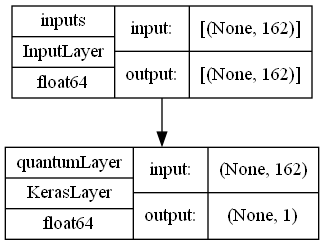

In [27]:
def frqi_embedding(encoded_inputs, n_qubits):
    n_values = len(encoded_inputs)
    n_padding = 2**n_qubits - n_values
    state_vector = np.pad(encoded_inputs, (0, n_padding), constant_values=(0, 0))
    qml.QubitStateVector(state_vector, wires=range(n_qubits))


def create_quantum_model(n_qubits, n_layers, gate_sequence, input_shape, weight_shape=(n_layers, 2*(n_qubits-1)+1, 3) ,encoding="basis", diff_method="adjoint"):
    print("Number of qubits: ", n_qubits)
    print("Number of layers: ", n_layers)
    print("Gate sequence: ", gate_sequence)
    print("Input shape: ", input_shape)
    print("Weight shape: ", weight_shape)
    print("Encoding: ", encoding)
    print("Diff method: ", diff_method)

    dev = qml.device("default.qubit", wires=n_qubits)

    @qml.qnode(dev, diff_method=diff_method)  # ["best","backprop","adjoint","device","parameter-shift","finite-diff","hadamard","spsa"]
    def qnode(inputs, weights):
        # Apply input rotations
        if encoding=="basis":
            for i in range(n_qubits):
                qml.RY(np.pi * inputs[i], wires=i)
        elif encoding=="amplitude":
            qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits),normalize=True,pad_with=0)
        elif encoding=="FRQI":
            # frqi_embedding(inputs, n_qubits)
            qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits),normalize=False,pad_with=0)
            
        measurement_output = []
        # Apply quantum layers
        
        for gate_type, control_wire, target_wire, weight_idx in gate_sequence:
            if gate_type == "RY":
                qml.RY(weights[weight_idx[0][0], weight_idx[0][1], weight_idx[0][2]], wires=target_wire)
            elif gate_type == "RZ":
                qml.RZ(weights[weight_idx[0][0], weight_idx[0][1], weight_idx[0][2]], wires=target_wire)
            elif gate_type == "RX":
                qml.RX(weights[weight_idx[0][0], weight_idx[0][1], weight_idx[0][2]], wires=target_wire)
            elif gate_type == "U1":
                qml.U1(weights[weight_idx[0][0], weight_idx[0][1], weight_idx[0][2]], wires=target_wire)
            elif gate_type == "U2":
                qml.U2(weights[weight_idx[0][0], weight_idx[0][1], weight_idx[0][2]], weights[weight_idx[1][0], weight_idx[1][1], weight_idx[1][2]], wires=target_wire)
            elif gate_type == "U3":
                qml.U3(weights[weight_idx[0][0], weight_idx[0][1], weight_idx[0][2]], weights[weight_idx[1][0], weight_idx[1][1], weight_idx[1][2]], weights[weight_idx[2][0], weight_idx[2][1], weight_idx[2][2]], wires=target_wire)
            elif gate_type == "CNOT":
                qml.CNOT(wires=[control_wire, target_wire])
            elif gate_type == "CZ":
                qml.CZ(wires=[control_wire, target_wire])

            elif gate_type == "Z":
                    # Measure the expectation value of Pauli-Z on target wire
                    measurement_output.append(qml.PauliZ(target_wire))
            # Add more gate types here as needed

        if len (measurement_output) > 1:
            final_measurement_output = Tensor(*measurement_output)
        else:
            final_measurement_output = measurement_output[0]
        
        return qml.expval(final_measurement_output)

    # Define weight shapes for the KerasLayer
    weight_shapes = {"weights": weight_shape}

    # Create the quantum layer with the qnode and weight_shapes
    qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")

    # Create the Keras input layer with the shape of the inputs
    inputs = tf.keras.Input(shape=(input_shape,), name="inputs")

    # Connect the quantum layer to the inputs
    outputs = qlayer(inputs)

    # Create the Keras model with the inputs and outputs
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

    return model, qnode


gate_sequence = []
n_layers = 2
for layer in range(n_layers):
    for ii in range(n_qubits - 1):
        gate_sequence.extend([
            ("RZ", None, 0, [(layer, 2 * ii, 0)]),
            ("RY", None, 0, [(layer, 2 * ii, 1)]),
            ("RZ", None, 0, [(layer, 2 * ii, 2)]),
            ("RZ", None, ii + 1, [(layer, 2 * ii + 1, 0)]),
            ("RY", None, ii + 1, [(layer, 2 * ii + 1, 1)]),
            ("RZ", None, ii + 1, [(layer, 2 * ii + 1, 2)]),
            ("CNOT", ii + 1, 0, None)
        ])

gate_sequence.extend([
    ("RZ", None, 0, [(layer, 2 * (n_qubits - 1), 0)]),
    ("RY", None, 0, [(layer, 2 * (n_qubits - 1), 1)]),
    ("RZ", None, 0, [(layer, 2 * (n_qubits - 1), 2)])
])

gate_sequence.extend([
    ("Z", None, 0, None)
    ])

print(len(gate_sequence))
pprint(gate_sequence)

test_model, test_q_node = create_quantum_model(n_qubits, n_layers, gate_sequence, input_shape=x_train_frqi_encoded.shape[1], encoding="FRQI", diff_method="adjoint")
print("input_shape", x_train_frqi_encoded.shape[1])
test_model.predict(x_train_frqi_encoded[0,:].reshape(1, -1))#[0,:].reshape(1, -1))
print(test_model.summary())
plot_model(test_model, to_file="test_quantum_ml_model.png", show_shapes=True, show_dtype=True, show_layer_names=True)

In [28]:
sample_inputs = np.random.rand(n_qubits)
sample_inputs.shape

(8,)

In [29]:
def draw_quantum_circuit(q_node, n_qubits, n_layers, sample_inputs=np.random.rand(n_qubits), sample_weights=np.random.rand(n_layers, 2*(n_qubits-1)+1, 3)):
    circuit_diagram = qml.draw(q_node)

    print(circuit_diagram(sample_inputs, sample_weights))

In [30]:
draw_quantum_circuit(test_q_node, n_qubits, n_layers,x_train_frqi_encoded)

0: ─╭AmplitudeEmbedding(M0)──RZ(0.33)──RY(0.22)──RZ(0.26)─╭X──RZ(0.68)──RY(0.04)──RZ(0.69)─╭X
1: ─├AmplitudeEmbedding(M0)──RZ(0.80)──RY(0.40)──RZ(0.08)─╰●───────────────────────────────│─
2: ─├AmplitudeEmbedding(M0)──RZ(0.22)──RY(0.05)──RZ(0.09)──────────────────────────────────╰●
3: ─├AmplitudeEmbedding(M0)──RZ(0.95)──RY(0.28)──RZ(0.02)────────────────────────────────────
4: ─├AmplitudeEmbedding(M0)──RZ(0.05)──RY(0.48)──RZ(0.32)────────────────────────────────────
5: ─├AmplitudeEmbedding(M0)──RZ(0.13)──RY(0.15)──RZ(0.87)────────────────────────────────────
6: ─├AmplitudeEmbedding(M0)──RZ(0.11)──RY(0.74)──RZ(0.55)────────────────────────────────────
7: ─╰AmplitudeEmbedding(M0)──RZ(0.16)──RY(0.99)──RZ(0.27)────────────────────────────────────

───RZ(0.69)──RY(0.93)──RZ(0.71)─╭X──RZ(0.21)──RY(0.23)──RZ(0.12)─╭X──RZ(0.46)──RY(0.84)──RZ(0.97)─╭X
────────────────────────────────│────────────────────────────────│────────────────────────────────│─
────────────────────────────────│────────────

In [31]:
def get_hinge_labels(labels):
    return 2.0*labels - 1.0

In [32]:
y_train_hinge = get_hinge_labels(y_train_final)
y_test_hinge = get_hinge_labels(y_test_final)
y_train_hinge[:10]

array([-1., -1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1.])

In [33]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

## Compile and train model

In [34]:
EPOCHS = 20 # Number of training epochs
BATCH_SIZE = 32 # Number of examples used in each training step

NUM_EXAMPLES = 512 # Number of examples to train on

In [35]:
test_model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [36]:
x_train_sub = x_train_final[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]
print(x_train_sub.shape, y_train_hinge_sub.shape)

x_test_sub = x_test_final[:,:]
y_test_sub = y_test_filtered[:]
print(x_test_sub.shape, y_test_sub.shape)

(512, 81) (512,)
(12049, 81) (1968,)


In [37]:
# x_train_sub = x_train_final[:NUM_EXAMPLES,:]
# y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

# x_test_sub = x_test_final[:,:]
# y_test_sub = y_test_hinge[:]

# qnn_history_1layer = test_model.fit(
#       x_train_sub, y_train_hinge_sub,
#       batch_size=BATCH_SIZE,
#       epochs=EPOCHS,
#       verbose=1,
#       validation_data=(x_test_sub, y_test_sub))

# qnn_results_1layer = test_model.evaluate(x_test_sub, y_test_sub)

In [38]:
# qnn_history_1layer.history

## Experimentation

In [39]:
gate_sequence_list = []

# ansatz 1
n_qubits=9
print(n_qubits)
gate_sequence_1 = []
for ii in range(n_qubits - 1):
    gate_sequence_1.extend([
        ("RZ", None, 0, (2 * ii, 0)),
        ("RY", None, 0, (2 * ii, 1)),
        ("RZ", None, 0, (2 * ii, 2)),
        ("RZ", None, ii + 1, (2 * ii + 1, 0)),
        ("RY", None, ii + 1, (2 * ii + 1, 1)),
        ("RZ", None, ii + 1, (2 * ii + 1, 2)),
        ("CNOT", ii + 1, 0, None),
    ])

gate_sequence_1.extend([
    ("RZ", None, 0, (2 * (n_qubits - 1), 0)),
    ("RY", None, 0, (2 * (n_qubits - 1), 1)),
    ("RZ", None, 0, (2 * (n_qubits - 1), 2)),
])
gate_sequence_list.append(gate_sequence_1)

# ansatz 1
n_qubits=7
print(n_qubits)
gate_sequence_2 = []
for ii in range(n_qubits - 1):
    gate_sequence_2.extend([
        ("RZ", None, 0, (2 * ii, 0)),
        ("RY", None, 0, (2 * ii, 1)),
        ("RZ", None, 0, (2 * ii, 2)),
        ("RZ", None, ii + 1, (2 * ii + 1, 0)),
        ("RY", None, ii + 1, (2 * ii + 1, 1)),
        ("RZ", None, ii + 1, (2 * ii + 1, 2)),
        ("CNOT", ii + 1, 0, None),
    ])

gate_sequence_2.extend([
    ("RZ", None, 0, (2 * (n_qubits - 1), 0)),
    ("RY", None, 0, (2 * (n_qubits - 1), 1)),
    ("RZ", None, 0, (2 * (n_qubits - 1), 2)),
])
gate_sequence_list.append(gate_sequence_2)

# ansatz 1
n_qubits=8
print(n_qubits)
gate_sequence_3 = []
for ii in range(n_qubits - 1):
    gate_sequence_3.extend([
        ("RZ", None, 0, (2 * ii, 0)),
        ("RY", None, 0, (2 * ii, 1)),
        ("RZ", None, 0, (2 * ii, 2)),
        ("RZ", None, ii + 1, (2 * ii + 1, 0)),
        ("RY", None, ii + 1, (2 * ii + 1, 1)),
        ("RZ", None, ii + 1, (2 * ii + 1, 2)),
        ("CNOT", ii + 1, 0, None),
    ])

gate_sequence_3.extend([
    ("RZ", None, 0, (2 * (n_qubits - 1), 0)),
    ("RY", None, 0, (2 * (n_qubits - 1), 1)),
    ("RZ", None, 0, (2 * (n_qubits - 1), 2)),
])
gate_sequence_list.append(gate_sequence_3)

# ansatz 1
n_qubits=10
print(n_qubits)
gate_sequence_4 = []
for ii in range(n_qubits - 1):
    gate_sequence_4.extend([
        ("RZ", None, 0, (2 * ii, 0)),
        ("RY", None, 0, (2 * ii, 1)),
        ("RZ", None, 0, (2 * ii, 2)),
        ("RZ", None, ii + 1, (2 * ii + 1, 0)),
        ("RY", None, ii + 1, (2 * ii + 1, 1)),
        ("RZ", None, ii + 1, (2 * ii + 1, 2)),
        ("CNOT", ii + 1, 0, None),
    ])

gate_sequence_4.extend([
    ("RZ", None, 0, (2 * (n_qubits - 1), 0)),
    ("RY", None, 0, (2 * (n_qubits - 1), 1)),
    ("RZ", None, 0, (2 * (n_qubits - 1), 2)),
])
gate_sequence_list.append(gate_sequence_4)

# ansatz 1
n_qubits=11
print(n_qubits)
gate_sequence_5 = []
for ii in range(n_qubits - 1):
    gate_sequence_5.extend([
        ("RZ", None, 0, (2 * ii, 0)),
        ("RY", None, 0, (2 * ii, 1)),
        ("RZ", None, 0, (2 * ii, 2)),
        ("RZ", None, ii + 1, (2 * ii + 1, 0)),
        ("RY", None, ii + 1, (2 * ii + 1, 1)),
        ("RZ", None, ii + 1, (2 * ii + 1, 2)),
        ("CNOT", ii + 1, 0, None),
    ])

gate_sequence_5.extend([
    ("RZ", None, 0, (2 * (n_qubits - 1), 0)),
    ("RY", None, 0, (2 * (n_qubits - 1), 1)),
    ("RZ", None, 0, (2 * (n_qubits - 1), 2)),
])
gate_sequence_list.append(gate_sequence_5)


print(len(gate_sequence_list))
print(len(gate_sequence_list[0]), len(gate_sequence_list[1]), len(gate_sequence_list[2]), len(gate_sequence_list[3]), len(gate_sequence_list[4]))
gate_sequence_list[0]

9
7
8
10
11
5
59 45 52 66 73


[('RZ', None, 0, (0, 0)),
 ('RY', None, 0, (0, 1)),
 ('RZ', None, 0, (0, 2)),
 ('RZ', None, 1, (1, 0)),
 ('RY', None, 1, (1, 1)),
 ('RZ', None, 1, (1, 2)),
 ('CNOT', 1, 0, None),
 ('RZ', None, 0, (2, 0)),
 ('RY', None, 0, (2, 1)),
 ('RZ', None, 0, (2, 2)),
 ('RZ', None, 2, (3, 0)),
 ('RY', None, 2, (3, 1)),
 ('RZ', None, 2, (3, 2)),
 ('CNOT', 2, 0, None),
 ('RZ', None, 0, (4, 0)),
 ('RY', None, 0, (4, 1)),
 ('RZ', None, 0, (4, 2)),
 ('RZ', None, 3, (5, 0)),
 ('RY', None, 3, (5, 1)),
 ('RZ', None, 3, (5, 2)),
 ('CNOT', 3, 0, None),
 ('RZ', None, 0, (6, 0)),
 ('RY', None, 0, (6, 1)),
 ('RZ', None, 0, (6, 2)),
 ('RZ', None, 4, (7, 0)),
 ('RY', None, 4, (7, 1)),
 ('RZ', None, 4, (7, 2)),
 ('CNOT', 4, 0, None),
 ('RZ', None, 0, (8, 0)),
 ('RY', None, 0, (8, 1)),
 ('RZ', None, 0, (8, 2)),
 ('RZ', None, 5, (9, 0)),
 ('RY', None, 5, (9, 1)),
 ('RZ', None, 5, (9, 2)),
 ('CNOT', 5, 0, None),
 ('RZ', None, 0, (10, 0)),
 ('RY', None, 0, (10, 1)),
 ('RZ', None, 0, (10, 2)),
 ('RZ', None, 6, (11, 0)

In [59]:
ansatz_1_architecture_spec_dict = {
    'wire_loop_gates': ['RZ', 'RY', 'RZ'],
    'entangler_loop_gates': ['CNOT'],
    'weight_shape': (15, 3),
    'pre_measurement_gates': ['RZ', 'RY', 'RZ'],
    'measurement_gates': [("Z", 0)],
    'entangle_strategy': {'strategy':'all_to_one', 'target_wire':0},
    'n_qubits': 8,
    'n_layers': 1,
}

gate_sequence_output = create_gate_sequence(ansatz_1_architecture_spec_dict)
pprint(gate_sequence_output)

n_qubits = ansatz_1_architecture_spec_dict['n_qubits']
n_layers=  ansatz_1_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_1_architecture_spec_dict['weight_shape'][0], max(len(ansatz_1_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_1_architecture_spec_dict['wire_loop_gates'][0])))
test_model_1, test_q_node_1 = create_quantum_model(n_qubits, n_layers, gate_sequence_output, input_shape=x_train_frqi_encoded.shape[1], weight_shape=weight_shape, encoding="FRQI", diff_method="adjoint")
print("input_shape", x_train_frqi_encoded.shape[1])
test_model.predict(x_train_frqi_encoded[0,:].reshape(1, -1))
print(test_model.summary())

sample_inputs = x_train_frqi_encoded
sample_weights = np.random.rand(*weight_shape)

# circuit_diagram = qml.draw(test_q_node_1)
# circuit_diagram(sample_inputs, sample_weights)

draw_quantum_circuit(test_q_node_1, n_qubits, n_layers, sample_inputs, sample_weights)

[('RZ', None, 0, [(0, 0, 0)]),
 ('RY', None, 0, [(0, 0, 1)]),
 ('RZ', None, 0, [(0, 0, 2)]),
 ('RZ', None, 1, [(0, 1, 0)]),
 ('RY', None, 1, [(0, 1, 1)]),
 ('RZ', None, 1, [(0, 1, 2)]),
 ('CNOT', 1, 0, None),
 ('RZ', None, 0, [(0, 2, 0)]),
 ('RY', None, 0, [(0, 2, 1)]),
 ('RZ', None, 0, [(0, 2, 2)]),
 ('RZ', None, 2, [(0, 3, 0)]),
 ('RY', None, 2, [(0, 3, 1)]),
 ('RZ', None, 2, [(0, 3, 2)]),
 ('CNOT', 2, 0, None),
 ('RZ', None, 0, [(0, 4, 0)]),
 ('RY', None, 0, [(0, 4, 1)]),
 ('RZ', None, 0, [(0, 4, 2)]),
 ('RZ', None, 3, [(0, 5, 0)]),
 ('RY', None, 3, [(0, 5, 1)]),
 ('RZ', None, 3, [(0, 5, 2)]),
 ('CNOT', 3, 0, None),
 ('RZ', None, 0, [(0, 6, 0)]),
 ('RY', None, 0, [(0, 6, 1)]),
 ('RZ', None, 0, [(0, 6, 2)]),
 ('RZ', None, 4, [(0, 7, 0)]),
 ('RY', None, 4, [(0, 7, 1)]),
 ('RZ', None, 4, [(0, 7, 2)]),
 ('CNOT', 4, 0, None),
 ('RZ', None, 0, [(0, 8, 0)]),
 ('RY', None, 0, [(0, 8, 1)]),
 ('RZ', None, 0, [(0, 8, 2)]),
 ('RZ', None, 5, [(0, 9, 0)]),
 ('RY', None, 5, [(0, 9, 1)]),
 ('RZ', N

In [51]:
def get_digit(string):
    #get digit from string , if there are no digits, return 0
    return int(''.join(filter(str.isdigit, string))) if ''.join(filter(str.isdigit, string)) else 0


def create_gate_sequence(ansatz_architecture_spec_dict):
    wire_loop_gates = ansatz_architecture_spec_dict['wire_loop_gates']
    entangler_loop_gates = ansatz_architecture_spec_dict['entangler_loop_gates']
    weight_shape = ansatz_architecture_spec_dict['weight_shape']
    pre_measurement_gates = ansatz_architecture_spec_dict['pre_measurement_gates']
    entangle_strategy = ansatz_architecture_spec_dict['entangle_strategy']
    n_qubits = ansatz_architecture_spec_dict['n_qubits']
    n_layers = ansatz_architecture_spec_dict['n_layers']
    measurement_gates = ansatz_architecture_spec_dict['measurement_gates']

    gate_sequence = []
    
    
    for layer in range(n_layers):
        sub_gate_sequence_1= []
        sub_gate_sequence_2= []
        sub_gate_sequence_3= []
        for qubit_index in range(n_qubits-1):

            if entangle_strategy['strategy'] == 'all_to_one':
                
                for idx, gate in enumerate(wire_loop_gates):
                    if "2" in gate:
                        gate_sequence.append((gate, None, entangle_strategy['target_wire'], [(layer, 2 * qubit_index, idx), (layer, 2 * qubit_index, idx+1)]))
                    elif "3" in gate: 
                        gate_sequence.append((gate, None, entangle_strategy['target_wire'], [(layer, 2 * qubit_index, idx), (layer, 2 * qubit_index, idx+1), (layer, 2 * qubit_index, idx+2)]))
                    else:
                        gate_sequence.append((gate, None, entangle_strategy['target_wire'], [(layer, 2 * qubit_index, idx)]))
                for idx, gate in enumerate(wire_loop_gates):
                    if "2" in gate:
                        gate_sequence.append((gate, None,  qubit_index+1, [(layer, 2 * qubit_index+1, idx), (layer, 2 * qubit_index+1, idx+1)]))
                    elif "3" in gate: 
                        gate_sequence.append((gate, None,  qubit_index+1, [(layer, 2 * qubit_index+1, idx), (layer, 2 * qubit_index+1, idx+1), (layer, 2 * qubit_index+1, idx+2)]))
                    else:
                        gate_sequence.append((gate, None, qubit_index+1, [(layer, 2 * qubit_index+1, idx)]))

                for entangler_gate in entangler_loop_gates:
                    gate_sequence.append((entangler_gate, qubit_index+1, entangle_strategy['target_wire'], None))
                    
            elif entangle_strategy['strategy'] == 'strong_entanglement-adjacent':
                for idx, gate in enumerate(wire_loop_gates):
                    if "2" in gate:
                        sub_gate_sequence_1.append((gate, None, qubit_index, [(layer, qubit_index, idx), (layer, qubit_index, idx+1)]))
                    elif "3" in gate: 
                        sub_gate_sequence_1.append((gate, None, qubit_index, [(layer, qubit_index, idx), (layer, qubit_index, idx+1), (layer, qubit_index, idx+2)]))
                    else:
                        sub_gate_sequence_1.append((gate, None, qubit_index, [(layer, qubit_index, idx)]))
                if qubit_index+1 == n_qubits-1:
                    for idx, gate in enumerate(wire_loop_gates):
                        if "2" in gate:
                            sub_gate_sequence_1.append((gate, None, qubit_index+1, [(layer, qubit_index+1, idx), (layer, qubit_index+1, idx+1)]))
                        elif "3" in gate: 
                            sub_gate_sequence_1.append((gate, None, qubit_index+1, [(layer, qubit_index+1, idx), (layer, qubit_index+1, idx+1), (layer, qubit_index+1, idx+2)]))
                        else:
                            sub_gate_sequence_1.append((gate, None, qubit_index+1, [(layer, qubit_index+1, idx)]))
                
                for entangler_gate in entangler_loop_gates:
                    sub_gate_sequence_2.append((entangler_gate, qubit_index, qubit_index+1, None))
                
                if qubit_index+1 == n_qubits-1:
                    for entangler_gate in entangler_loop_gates:
                        sub_gate_sequence_2.append((entangler_gate, qubit_index+1, 0, None))
                


            elif entangle_strategy['strategy'] == 'strong_entanglement-alternate':
                for idx, gate in enumerate(wire_loop_gates):
                    if "2" in gate:
                        sub_gate_sequence_1.append((gate, None, qubit_index, [(layer, qubit_index, idx), (layer, qubit_index, idx+1)]))
                    elif "3" in gate: 
                        sub_gate_sequence_1.append((gate, None, qubit_index, [(layer, qubit_index, idx), (layer, qubit_index, idx+1), (layer, qubit_index, idx+2)]))
                    else:
                        sub_gate_sequence_1.append((gate, None, qubit_index, [(layer, qubit_index, idx)]))
                if qubit_index+1 == n_qubits-1:
                    for idx, gate in enumerate(wire_loop_gates):
                        if "2" in gate:
                            sub_gate_sequence_1.append((gate, None, qubit_index+1, [(layer, qubit_index+1, idx), (layer, qubit_index+1, idx+1)]))
                        elif "3" in gate: 
                            sub_gate_sequence_1.append((gate, None, qubit_index+1, [(layer, qubit_index+1, idx), (layer, qubit_index+1, idx+1), (layer, qubit_index+1, idx+2)]))
                        else:
                            sub_gate_sequence_1.append((gate, None, qubit_index+1, [(layer, qubit_index+1, idx)]))
                
                if qubit_index+2 <= n_qubits-1:
                    for entangler_gate in entangler_loop_gates:
                        sub_gate_sequence_2.append((entangler_gate, qubit_index, qubit_index+2, None))
                else:
                    for entangler_gate in entangler_loop_gates:
                        sub_gate_sequence_2.append((entangler_gate, qubit_index, 0, None))
                

                
                # if qubit_index+2 <= n_qubits-1:
                #     for entangler_gate in entangler_loop_gates:
                #         sub_gate_sequence_3.append((entangler_gate, qubit_index+2, qubit_index, None))
                
                
            elif entangle_strategy['strategy'] == 'random':
                random_qubits = random.sample(range(n_qubits), 2)
                control_wire, target_wire = random_qubits

                for idx, gate in enumerate(wire_loop_gates):
                    gate_sequence.append((gate, None, control_wire, [(layer, 2 * qubit_index, idx)]))
                for idx, gate in enumerate(wire_loop_gates):
                    gate_sequence.append((gate, None, target_wire, [(layer, 2 * qubit_index+1, idx)]))

                for entangler_gate in entangler_loop_gates:
                    gate_sequence.append((entangler_gate, control_wire, target_wire, None))


            elif entangle_strategy['strategy'] == 'strong_entanglement':
                for idx, gate in enumerate(wire_loop_gates):
                    gate_sequence.append((gate, None, qubit_index, [(layer, 2 * qubit_index, idx)]))
                for idx, gate in enumerate(wire_loop_gates):
                    gate_sequence.append((gate, None, qubit_index+1, [(layer, 2 * qubit_index+1, idx)]))

                for entangler_gate in entangler_loop_gates:
                    control_wire = qubit_index if qubit_index % 2 == 0 else (qubit_index+1) % n_qubits
                    target_wire = (qubit_index+1) % n_qubits if qubit_index % 2 == 0 else qubit_index
                    gate_sequence.append((entangler_gate, control_wire, target_wire, None))


            elif entangle_strategy['strategy'] == 'circular':

                for idx, gate in enumerate(wire_loop_gates):
                    gate_sequence.append((gate, None, qubit_index, [(layer, 2 * qubit_index, idx)]))
                for idx, gate in enumerate(wire_loop_gates):
                    gate_sequence.append((gate, None, (qubit_index+1) % n_qubits, [(layer, 2 * qubit_index+1, idx)]))
                for entangler_gate in entangler_loop_gates:
                    gate_sequence.append((entangler_gate, qubit_index, (qubit_index+1) % n_qubits, None))


            elif entangle_strategy['strategy'] == 'star':  # same as "many_to_one"
                central_wire = entangle_strategy['central_wire']

                for idx, gate in enumerate(wire_loop_gates):
                    gate_sequence.append((gate, None, central_wire, [(layer, 2 * qubit_index, idx)]))
                for idx, gate in enumerate(wire_loop_gates):
                    gate_sequence.append((gate, None, qubit_index+1, [(layer, 2 * qubit_index+1, idx)]))

                for entangler_gate in entangler_loop_gates:
                    if qubit_index+1 != central_wire:
                        gate_sequence.append((entangler_gate, central_wire, qubit_index+1, None))

            elif entangle_strategy['strategy'] == 'tree':
                central_wire = entangle_strategy['central_wire']
                n_layers = entangle_strategy['n_layers']
                n_branches = entangle_strategy['n_branches']

                for idx, gate in enumerate(wire_loop_gates):
                    gate_sequence.append((gate, None, central_wire, [(layer, 2 * qubit_index, idx)]))
                for idx, gate in enumerate(wire_loop_gates):
                    gate_sequence.append((gate, None, qubit_index+1, [(layer, 2 * qubit_index+1, idx)]))

                for entangler_gate in entangler_loop_gates:
                    if qubit_index+1 != central_wire:
                        gate_sequence.append((entangler_gate, central_wire, qubit_index+1, None))

            elif entangle_strategy['strategy'] == 'custom':
                for idx, gate in enumerate(wire_loop_gates):
                    
                    if "2" in gate:
                        sub_gate_sequence_1.append((gate, None, qubit_index, [(layer, qubit_index, idx), (layer, qubit_index, idx+1)]))
                    elif "3" in gate: 
                        sub_gate_sequence_1.append((gate, None, qubit_index, [(layer, qubit_index, idx), (layer, qubit_index, idx+1), (layer, qubit_index, idx+2)]))
                    else:
                        sub_gate_sequence_1.append((gate, None, qubit_index, [(layer, qubit_index, idx)]))
                if qubit_index+1 == n_qubits-1:
                    for idx, gate in enumerate(wire_loop_gates):                           
                        if "2" in gate:
                            sub_gate_sequence_1.append((gate, None, qubit_index+1, [(layer, qubit_index+1, idx), (layer, qubit_index+1, idx)]))
                        elif "3" in gate: 
                            sub_gate_sequence_1.append((gate, None, qubit_index+1, [(layer, qubit_index+1, idx), (layer, qubit_index+1, idx+1), (layer, qubit_index+1, idx+2)]))
                        else:
                            sub_gate_sequence_1.append((gate, None, qubit_index+1, [(layer, qubit_index+1, idx)]))

                if qubit_index % 2 == 0:
                    for entangler_gate in entangler_loop_gates:
                        sub_gate_sequence_2.append((entangler_gate, qubit_index, qubit_index+1, None))
                else:
                    for entangler_gate in entangler_loop_gates:
                        sub_gate_sequence_3.append((entangler_gate, qubit_index, qubit_index+1, None))

            else:
                raise ValueError('Unknown entangle strategy')

        # Add sub-gate sequences
        if entangle_strategy['strategy'] in ['strong_entanglement-adjacent', 'strong_entanglement-alternate']:
            gate_sequence.extend(sub_gate_sequence_1)
            gate_sequence.extend(sub_gate_sequence_2)
            gate_sequence.extend(sub_gate_sequence_3)
        elif entangle_strategy['strategy'] == 'custom':
            gate_sequence.extend(sub_gate_sequence_1)
            gate_sequence.extend(sub_gate_sequence_2)
            gate_sequence.extend(sub_gate_sequence_3)

    sub_gate_sequence_4 = []
    sub_gate_sequence_5 = []
    
    for i, (measurement_gate, target_wire) in enumerate(measurement_gates):
        # print(i, (measurement_gate, target_wire))
        # Add pre-measurement gates for the target qubits/wires
        for idx, gate in enumerate(pre_measurement_gates):
            # print(idx, gate)
            if "2" in gate:
                if entangle_strategy['strategy'] == 'custom':
                    weights = [(layer, (weight_shape[0]-(n_qubits-i)), idx), (layer, (weight_shape[0]-(n_qubits-i)), idx+1)]
                else:
                    weights = [(layer,  2*(n_qubits-1), idx), (layer,  2*(n_qubits-1), idx+1)]
                sub_gate_sequence_4.append((gate, None, target_wire, weights))
            elif "3" in gate: 
                if entangle_strategy['strategy'] == 'custom':
                    weights = [(layer, (weight_shape[0]-(n_qubits-i)), idx), (layer, (weight_shape[0]-(n_qubits-i)), idx+1), (layer, (weight_shape[0]-(n_qubits-i)), idx+2)]
                else:
                    weights = [(layer,  2*(n_qubits-1), idx), (layer, 2*(n_qubits-1), idx+1), (layer,  2*(n_qubits-1), idx+2)]
                sub_gate_sequence_4.append((gate, None, target_wire, weights))
            else:
                if entangle_strategy['strategy'] == 'custom':
                    weights = [(layer, (weight_shape[0]-(n_qubits-i)), idx)]
                elif entangle_strategy['strategy'] == 'strong_entanglement-adjacent':
                    weights = [(layer,  n_qubits, idx)]
                else:
                    weights = [(layer,  2*(n_qubits-1), idx)]
                sub_gate_sequence_4.append((gate, None, target_wire, weights))

    gate_sequence.extend(sub_gate_sequence_4)

    # Add measurement gates
    for i, (measurement_gate, target_wire) in enumerate(measurement_gates):
        
        gate_sequence.append((measurement_gate, None, target_wire, None))
        

    return gate_sequence



In [42]:
ansatz_4a_architecture_spec_dict = {
    'wire_loop_gates': ['RY'],
    'entangler_loop_gates': ['CZ'],
    'weight_shape': (19, 1),
    'pre_measurement_gates': ['RY'],
    'measurement_gates': [("Z", 2)],
    'entangle_strategy': {'strategy':'alternate', 'target_wire':0},
    'n_qubits': 8,
    'n_layers': 1,
}


gate_sequence_output = create_gate_sequence(ansatz_4a_architecture_spec_dict)
# pprint(gate_sequence_output)

n_qubits = ansatz_4a_architecture_spec_dict['n_qubits']
n_layers= ansatz_4a_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_4a_architecture_spec_dict['weight_shape'][0], len(ansatz_4a_architecture_spec_dict['wire_loop_gates']))
test_model_1, test_q_node_1 = create_quantum_model(n_qubits, n_layers, gate_sequence_output, input_shape=x_train_frqi_encoded.shape[1], weight_shape=weight_shape, encoding="FRQI", diff_method="adjoint")
print("input_shape", x_train_frqi_encoded.shape[1])
test_model.predict(x_train_frqi_encoded[0,:].reshape(1, -1))
print(test_model.summary())

sample_inputs = x_train_frqi_encoded
sample_weights = np.random.rand(*weight_shape)


draw_quantum_circuit(test_q_node_1, n_qubits, n_layers, sample_inputs, sample_weights)

ValueError: Unknown entangle strategy

In [ ]:
ansatz_2_architecture_spec_dict = {
    'wire_loop_gates': ['RY'],
    'entangler_loop_gates': ['CNOT'],
    'weight_shape': (15, 1),
    'pre_measurement_gates': ['RY'],
    'measurement_gates': [("Z", 0)],
    'entangle_strategy': {'strategy':'all_to_one', 'target_wire':0},
    'n_qubits': 8,
    'n_layers': 3,
}


gate_sequence_output = create_gate_sequence(ansatz_2_architecture_spec_dict)
# pprint(gate_sequence_output)

n_qubits = ansatz_2_architecture_spec_dict['n_qubits']
n_layers=  ansatz_2_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_2_architecture_spec_dict['weight_shape'][0], max(len(ansatz_2_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_2_architecture_spec_dict['wire_loop_gates'][0])))
test_model_1, test_q_node_1 = create_quantum_model(n_qubits, n_layers, gate_sequence_output, input_shape=x_train_frqi_encoded.shape[1], weight_shape=weight_shape, encoding="FRQI", diff_method="adjoint")
print("input_shape", x_train_frqi_encoded.shape[1])
test_model.predict(x_train_frqi_encoded[0,:].reshape(1, -1))
print(test_model.summary())

sample_inputs = x_train_frqi_encoded
sample_weights = np.random.rand(*weight_shape)

draw_quantum_circuit(test_q_node_1, n_qubits, n_layers, sample_inputs, sample_weights)


Number of qubits:  8
Number of layers:  3
Gate sequence:  [('RY', None, 0, [(0, 0, 0)]), ('RY', None, 1, [(0, 1, 0)]), ('CNOT', 1, 0, None), ('RY', None, 0, [(0, 2, 0)]), ('RY', None, 2, [(0, 3, 0)]), ('CNOT', 2, 0, None), ('RY', None, 0, [(0, 4, 0)]), ('RY', None, 3, [(0, 5, 0)]), ('CNOT', 3, 0, None), ('RY', None, 0, [(0, 6, 0)]), ('RY', None, 4, [(0, 7, 0)]), ('CNOT', 4, 0, None), ('RY', None, 0, [(0, 8, 0)]), ('RY', None, 5, [(0, 9, 0)]), ('CNOT', 5, 0, None), ('RY', None, 0, [(0, 10, 0)]), ('RY', None, 6, [(0, 11, 0)]), ('CNOT', 6, 0, None), ('RY', None, 0, [(0, 12, 0)]), ('RY', None, 7, [(0, 13, 0)]), ('CNOT', 7, 0, None), ('RY', None, 0, [(1, 0, 0)]), ('RY', None, 1, [(1, 1, 0)]), ('CNOT', 1, 0, None), ('RY', None, 0, [(1, 2, 0)]), ('RY', None, 2, [(1, 3, 0)]), ('CNOT', 2, 0, None), ('RY', None, 0, [(1, 4, 0)]), ('RY', None, 3, [(1, 5, 0)]), ('CNOT', 3, 0, None), ('RY', None, 0, [(1, 6, 0)]), ('RY', None, 4, [(1, 7, 0)]), ('CNOT', 4, 0, None), ('RY', None, 0, [(1, 8, 0)]), ('RY'

In [ ]:
ansatz_3_architecture_spec_dict = {
    'wire_loop_gates': ['RZ'],
    'entangler_loop_gates': ['CZ'],
    'weight_shape': (15, 1),
    'pre_measurement_gates': ['RZ'],
    'measurement_gates': [("Z", 0)],
    'entangle_strategy': {'strategy':'all_to_one', 'target_wire':0},
    'n_qubits': 8,
    'n_layers': 3,
}

gate_sequence_output = create_gate_sequence(ansatz_3_architecture_spec_dict)
# pprint(gate_sequence_output)

n_qubits = ansatz_3_architecture_spec_dict['n_qubits']
n_layers= ansatz_3_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_3_architecture_spec_dict['weight_shape'][0], max(len(ansatz_3_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_3_architecture_spec_dict['wire_loop_gates'][0])))
test_model_1, test_q_node_1 = create_quantum_model(n_qubits, n_layers, gate_sequence_output, input_shape=x_train_frqi_encoded.shape[1], weight_shape=weight_shape, encoding="FRQI", diff_method="adjoint")
print("input_shape", x_train_frqi_encoded.shape[1])
test_model.predict(x_train_frqi_encoded[0,:].reshape(1, -1))
print(test_model.summary())

sample_inputs = x_train_frqi_encoded
sample_weights = np.random.rand(*weight_shape)


draw_quantum_circuit(test_q_node_1, n_qubits, n_layers, sample_inputs, sample_weights)

Number of qubits:  8
Number of layers:  3
Gate sequence:  [('RZ', None, 0, [(0, 0, 0)]), ('RZ', None, 1, [(0, 1, 0)]), ('CZ', 1, 0, None), ('RZ', None, 0, [(0, 2, 0)]), ('RZ', None, 2, [(0, 3, 0)]), ('CZ', 2, 0, None), ('RZ', None, 0, [(0, 4, 0)]), ('RZ', None, 3, [(0, 5, 0)]), ('CZ', 3, 0, None), ('RZ', None, 0, [(0, 6, 0)]), ('RZ', None, 4, [(0, 7, 0)]), ('CZ', 4, 0, None), ('RZ', None, 0, [(0, 8, 0)]), ('RZ', None, 5, [(0, 9, 0)]), ('CZ', 5, 0, None), ('RZ', None, 0, [(0, 10, 0)]), ('RZ', None, 6, [(0, 11, 0)]), ('CZ', 6, 0, None), ('RZ', None, 0, [(0, 12, 0)]), ('RZ', None, 7, [(0, 13, 0)]), ('CZ', 7, 0, None), ('RZ', None, 0, [(1, 0, 0)]), ('RZ', None, 1, [(1, 1, 0)]), ('CZ', 1, 0, None), ('RZ', None, 0, [(1, 2, 0)]), ('RZ', None, 2, [(1, 3, 0)]), ('CZ', 2, 0, None), ('RZ', None, 0, [(1, 4, 0)]), ('RZ', None, 3, [(1, 5, 0)]), ('CZ', 3, 0, None), ('RZ', None, 0, [(1, 6, 0)]), ('RZ', None, 4, [(1, 7, 0)]), ('CZ', 4, 0, None), ('RZ', None, 0, [(1, 8, 0)]), ('RZ', None, 5, [(1, 9, 0)]

In [ ]:

ansatz_4_architecture_spec_dict = {
    'wire_loop_gates': ['RY'],
    'entangler_loop_gates': ['CZ'],
    'weight_shape': (17, 1),
    'pre_measurement_gates': ['RY'],
    'measurement_gates': [("Z", 8)],
    'entangle_strategy': {'strategy':'adjacent', 'target_wire':1},
    'n_qubits': 8,
    'n_layers': 3,
}

gate_sequence_output = create_gate_sequence(ansatz_4_architecture_spec_dict)
pprint(gate_sequence_output)

n_qubits = ansatz_4_architecture_spec_dict['n_qubits']
n_layers= ansatz_4_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_4_architecture_spec_dict['weight_shape'][0], max(len(ansatz_4_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_4_architecture_spec_dict['wire_loop_gates'][0])))
test_model_1, test_q_node_1 = create_quantum_model(n_qubits, n_layers, gate_sequence_output, input_shape=x_train_frqi_encoded.shape[1], weight_shape=weight_shape, encoding="FRQI", diff_method="adjoint")
print("input_shape", x_train_frqi_encoded.shape[1])
test_model.predict(x_train_frqi_encoded[0,:].reshape(1, -1))
print(test_model.summary())

sample_inputs = x_train_frqi_encoded
sample_weights = np.random.rand(*weight_shape)

draw_quantum_circuit(test_q_node_1, n_qubits, n_layers, sample_inputs, sample_weights)


Number of qubits:  8
Number of layers:  3
Gate sequence:  [('RY', None, 0, [(0, 0, 0)]), ('RY', None, 1, [(0, 1, 0)]), ('CZ', 0, 1, None), ('RY', None, 1, [(0, 2, 0)]), ('RY', None, 2, [(0, 3, 0)]), ('CZ', 1, 2, None), ('RY', None, 2, [(0, 4, 0)]), ('RY', None, 3, [(0, 5, 0)]), ('CZ', 2, 3, None), ('RY', None, 3, [(0, 6, 0)]), ('RY', None, 4, [(0, 7, 0)]), ('CZ', 3, 4, None), ('RY', None, 4, [(0, 8, 0)]), ('RY', None, 5, [(0, 9, 0)]), ('CZ', 4, 5, None), ('RY', None, 5, [(0, 10, 0)]), ('RY', None, 6, [(0, 11, 0)]), ('CZ', 5, 6, None), ('RY', None, 6, [(0, 12, 0)]), ('RY', None, 7, [(0, 13, 0)]), ('CZ', 6, 7, None), ('RY', None, 0, [(1, 0, 0)]), ('RY', None, 1, [(1, 1, 0)]), ('CZ', 0, 1, None), ('RY', None, 1, [(1, 2, 0)]), ('RY', None, 2, [(1, 3, 0)]), ('CZ', 1, 2, None), ('RY', None, 2, [(1, 4, 0)]), ('RY', None, 3, [(1, 5, 0)]), ('CZ', 2, 3, None), ('RY', None, 3, [(1, 6, 0)]), ('RY', None, 4, [(1, 7, 0)]), ('CZ', 3, 4, None), ('RY', None, 4, [(1, 8, 0)]), ('RY', None, 5, [(1, 9, 0)]

In [43]:
ansatz_5_architecture_spec_dict = {
    'wire_loop_gates': ['U3'],
    'entangler_loop_gates': ['CZ'],
    'weight_shape': (16, 3),
    'pre_measurement_gates': ['U3'],
    'measurement_gates': [("Z", 0), ("Z", 1), ("Z", 2), ("Z", 3), ("Z", 4), ("Z", 5), ("Z", 6), ("Z", 7)],
    'entangle_strategy': {'strategy':'custom', 'target_wire':0},
    'n_qubits': 8,
    'n_layers': 3,
}

gate_sequence_output = create_gate_sequence(ansatz_5_architecture_spec_dict)
pprint(gate_sequence_output)

n_qubits = ansatz_5_architecture_spec_dict['n_qubits']
n_layers= ansatz_5_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_5_architecture_spec_dict['weight_shape'][0], max(len(ansatz_5_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_5_architecture_spec_dict['wire_loop_gates'][0])))
print(weight_shape)
test_model_1, test_q_node_1 = create_quantum_model(n_qubits, n_layers, gate_sequence_output, input_shape=x_train_frqi_encoded.shape[1], weight_shape=weight_shape, encoding="FRQI", diff_method="adjoint")
print("input_shape", x_train_frqi_encoded.shape[1])
test_model.predict(x_train_frqi_encoded[0,:].reshape(1, -1))
print(test_model.summary())

sample_inputs = x_train_frqi_encoded[0,:].reshape(1, -1)
sample_weights = np.random.rand(*weight_shape)

print(sample_inputs.shape)
print(sample_weights.shape)
draw_quantum_circuit(test_q_node_1, n_qubits, n_layers, sample_inputs, sample_weights)

[('U3', None, 0, [(0, 0, 0), (0, 0, 1), (0, 0, 2)]),
 ('U3', None, 1, [(0, 1, 0), (0, 1, 1), (0, 1, 2)]),
 ('U3', None, 2, [(0, 2, 0), (0, 2, 1), (0, 2, 2)]),
 ('U3', None, 3, [(0, 3, 0), (0, 3, 1), (0, 3, 2)]),
 ('U3', None, 4, [(0, 4, 0), (0, 4, 1), (0, 4, 2)]),
 ('U3', None, 5, [(0, 5, 0), (0, 5, 1), (0, 5, 2)]),
 ('U3', None, 6, [(0, 6, 0), (0, 6, 1), (0, 6, 2)]),
 ('U3', None, 7, [(0, 7, 0), (0, 7, 1), (0, 7, 2)]),
 ('CZ', 0, 1, None),
 ('CZ', 2, 3, None),
 ('CZ', 4, 5, None),
 ('CZ', 6, 7, None),
 ('CZ', 1, 2, None),
 ('CZ', 3, 4, None),
 ('CZ', 5, 6, None),
 ('U3', None, 0, [(1, 0, 0), (1, 0, 1), (1, 0, 2)]),
 ('U3', None, 1, [(1, 1, 0), (1, 1, 1), (1, 1, 2)]),
 ('U3', None, 2, [(1, 2, 0), (1, 2, 1), (1, 2, 2)]),
 ('U3', None, 3, [(1, 3, 0), (1, 3, 1), (1, 3, 2)]),
 ('U3', None, 4, [(1, 4, 0), (1, 4, 1), (1, 4, 2)]),
 ('U3', None, 5, [(1, 5, 0), (1, 5, 1), (1, 5, 2)]),
 ('U3', None, 6, [(1, 6, 0), (1, 6, 1), (1, 6, 2)]),
 ('U3', None, 7, [(1, 7, 0), (1, 7, 1), (1, 7, 2)]),
 ('CZ

In [44]:
ansatz_6_architecture_spec_dict = {
    'wire_loop_gates': ['RZ', 'RY', 'RZ'],
    'entangler_loop_gates': ['CNOT'],
    'weight_shape': (15, 3),
    'pre_measurement_gates': ['RZ', 'RY', 'RZ'],
    'measurement_gates': [("Z", 0)],
    'entangle_strategy': {'strategy':'strong_entanglement-adjacent', 'target_wire':0},
    'n_qubits': 8,
    'n_layers': 1,
}


gate_sequence_output = create_gate_sequence(ansatz_6_architecture_spec_dict)
# pprint(gate_sequence_output)

n_qubits = ansatz_6_architecture_spec_dict['n_qubits']
n_layers= ansatz_6_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_6_architecture_spec_dict['weight_shape'][0], max(len(ansatz_6_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_6_architecture_spec_dict['wire_loop_gates'][0])))
test_model_1, test_q_node_1 = create_quantum_model(n_qubits, n_layers, gate_sequence_output, input_shape=x_train_frqi_encoded.shape[1], weight_shape=weight_shape, encoding="FRQI", diff_method="adjoint")
print("input_shape", x_train_frqi_encoded.shape[1])
test_model.predict(x_train_frqi_encoded[0,:].reshape(1, -1))
print(test_model.summary())

sample_inputs = x_train_frqi_encoded
sample_weights = np.random.rand(*weight_shape)


draw_quantum_circuit(test_q_node_1, n_qubits, n_layers, sample_inputs, sample_weights)

Number of qubits:  8
Number of layers:  1
Gate sequence:  [('RZ', None, 0, [(0, 0, 0)]), ('RY', None, 0, [(0, 0, 1)]), ('RZ', None, 0, [(0, 0, 2)]), ('RZ', None, 1, [(0, 1, 0)]), ('RY', None, 1, [(0, 1, 1)]), ('RZ', None, 1, [(0, 1, 2)]), ('RZ', None, 2, [(0, 2, 0)]), ('RY', None, 2, [(0, 2, 1)]), ('RZ', None, 2, [(0, 2, 2)]), ('RZ', None, 3, [(0, 3, 0)]), ('RY', None, 3, [(0, 3, 1)]), ('RZ', None, 3, [(0, 3, 2)]), ('RZ', None, 4, [(0, 4, 0)]), ('RY', None, 4, [(0, 4, 1)]), ('RZ', None, 4, [(0, 4, 2)]), ('RZ', None, 5, [(0, 5, 0)]), ('RY', None, 5, [(0, 5, 1)]), ('RZ', None, 5, [(0, 5, 2)]), ('RZ', None, 6, [(0, 6, 0)]), ('RY', None, 6, [(0, 6, 1)]), ('RZ', None, 6, [(0, 6, 2)]), ('RZ', None, 7, [(0, 7, 0)]), ('RY', None, 7, [(0, 7, 1)]), ('RZ', None, 7, [(0, 7, 2)]), ('CNOT', 0, 1, None), ('CNOT', 1, 2, None), ('CNOT', 2, 3, None), ('CNOT', 3, 4, None), ('CNOT', 4, 5, None), ('CNOT', 5, 6, None), ('CNOT', 6, 7, None), ('CNOT', 7, 0, None), ('RZ', None, 0, [(0, 14, 0)]), ('RY', None, 0

In [45]:
ansatz_7_architecture_spec_dict = {
    'wire_loop_gates': ['RZ', 'RY', 'RZ'],
    'entangler_loop_gates': ['CNOT'],
    'weight_shape': (17, 3),
    'pre_measurement_gates': ['RZ', 'RY', 'RZ'],
    'measurement_gates': [("Z", 0)],
    'entangle_strategy': {'strategy':'strong_entanglement-alternate', 'target_wire':0},
    'n_qubits': 8,
    'n_layers': 1,
}


gate_sequence_output = create_gate_sequence(ansatz_7_architecture_spec_dict)
pprint(gate_sequence_output)

n_qubits = 8
n_layers= 1
weight_shape = (n_layers, ansatz_7_architecture_spec_dict['weight_shape'][0], len(ansatz_7_architecture_spec_dict['wire_loop_gates']))
test_model_1, test_q_node_1 = create_quantum_model(n_qubits, n_layers, gate_sequence_output, input_shape=x_train_frqi_encoded.shape[1], weight_shape=weight_shape, encoding="FRQI", diff_method="adjoint")
print("input_shape", x_train_frqi_encoded.shape[1])
test_model.predict(x_train_frqi_encoded[0,:].reshape(1, -1))
print(test_model.summary())

sample_inputs = x_train_frqi_encoded
sample_weights = np.random.rand(*weight_shape)


draw_quantum_circuit(test_q_node_1, n_qubits, n_layers, sample_inputs, sample_weights)

[('RZ', None, 0, [(0, 0, 0)]),
 ('RY', None, 0, [(0, 0, 1)]),
 ('RZ', None, 0, [(0, 0, 2)]),
 ('RZ', None, 1, [(0, 1, 0)]),
 ('RY', None, 1, [(0, 1, 1)]),
 ('RZ', None, 1, [(0, 1, 2)]),
 ('RZ', None, 2, [(0, 2, 0)]),
 ('RY', None, 2, [(0, 2, 1)]),
 ('RZ', None, 2, [(0, 2, 2)]),
 ('RZ', None, 3, [(0, 3, 0)]),
 ('RY', None, 3, [(0, 3, 1)]),
 ('RZ', None, 3, [(0, 3, 2)]),
 ('RZ', None, 4, [(0, 4, 0)]),
 ('RY', None, 4, [(0, 4, 1)]),
 ('RZ', None, 4, [(0, 4, 2)]),
 ('RZ', None, 5, [(0, 5, 0)]),
 ('RY', None, 5, [(0, 5, 1)]),
 ('RZ', None, 5, [(0, 5, 2)]),
 ('RZ', None, 6, [(0, 6, 0)]),
 ('RY', None, 6, [(0, 6, 1)]),
 ('RZ', None, 6, [(0, 6, 2)]),
 ('RZ', None, 7, [(0, 7, 0)]),
 ('RY', None, 7, [(0, 7, 1)]),
 ('RZ', None, 7, [(0, 7, 2)]),
 ('CNOT', 0, 2, None),
 ('CNOT', 1, 3, None),
 ('CNOT', 2, 4, None),
 ('CNOT', 3, 5, None),
 ('CNOT', 4, 6, None),
 ('CNOT', 5, 7, None),
 ('CNOT', 6, 0, None),
 ('RZ', None, 0, [(0, 14, 0)]),
 ('RY', None, 0, [(0, 14, 1)]),
 ('RZ', None, 0, [(0, 14, 2)]),

In [63]:
#---- ansatz 2 ----------------
ansatz_2_architecture_spec_dict = {
    'wire_loop_gates': ['RY'],
    'entangler_loop_gates': ['CNOT'],
    'weight_shape': (15, 1),
    'pre_measurement_gates': ['RY'],
    'measurement_gates': [("Z", 0)],
    'entangle_strategy': {'strategy':'all_to_one', 'target_wire':0},
    'n_qubits': 8,
    'n_layers': 1,
}
ansatz_2_gate_sequence = create_gate_sequence(ansatz_2_architecture_spec_dict)
# pprint(ansatz_2_gate_sequence)

n_qubits = ansatz_2_architecture_spec_dict['n_qubits']
n_layers= ansatz_2_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_2_architecture_spec_dict['weight_shape'][0], max(len(ansatz_2_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_2_architecture_spec_dict['entangler_loop_gates'])))
test_model_1, test_q_node_1 = create_quantum_model(n_qubits, n_layers, ansatz_2_gate_sequence, input_shape=x_train_frqi_encoded.shape[1], weight_shape=weight_shape, encoding="FRQI", diff_method="adjoint")
print("input_shape", x_train_frqi_encoded.shape[1])
test_model.predict(x_train_frqi_encoded[0,:].reshape(1, -1))
print("\n\n\n")
print(test_model.summary())

sample_inputs = x_train_frqi_encoded
sample_weights = np.random.rand(*weight_shape)
draw_quantum_circuit(test_q_node_1, n_qubits, n_layers, sample_inputs, sample_weights)
print("\n\n\n")

#---- ansatz 3 ----------------
ansatz_3_architecture_spec_dict = {
    'wire_loop_gates': ['RZ'],
    'entangler_loop_gates': ['CZ'],
    'weight_shape': (15, 1),
    'pre_measurement_gates': ['RZ'],
    'measurement_gates': [("Z", 0)],
    'entangle_strategy': {'strategy':'all_to_one', 'target_wire':0},
    'n_qubits': 8,
    'n_layers': 3,
}

ansatz_3_gate_sequence = create_gate_sequence(ansatz_3_architecture_spec_dict)
# pprint(ansatz_3_gate_sequence)

n_qubits = ansatz_3_architecture_spec_dict['n_qubits']
n_layers= ansatz_3_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_3_architecture_spec_dict['weight_shape'][0],  max(len(ansatz_3_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_3_architecture_spec_dict['wire_loop_gates'][0])))
test_model_1, test_q_node_1 = create_quantum_model(n_qubits, n_layers, ansatz_3_gate_sequence, input_shape=x_train_frqi_encoded.shape[1], weight_shape=weight_shape, encoding="FRQI", diff_method="adjoint")
print("input_shape", x_train_frqi_encoded.shape[1])
test_model.predict(x_train_frqi_encoded[0,:].reshape(1, -1))
# print(test_model.summary())

sample_inputs = x_train_frqi_encoded
sample_weights = np.random.rand(*weight_shape)
# draw_quantum_circuit(test_q_node_1, n_qubits, n_layers, sample_inputs, sample_weights)

#---- ansatz 4 ----------------
ansatz_4_architecture_spec_dict = {
    'wire_loop_gates': ['U3'],
    'entangler_loop_gates': ['CZ'],
    'weight_shape': (15, 3),
    'pre_measurement_gates': ['U3'],
    'measurement_gates': [("Z", 0)],
    'entangle_strategy': {'strategy':'all_to_one', 'target_wire':0},
    'n_qubits': 8,
    'n_layers': 3,
}

ansatz_4_gate_sequence = create_gate_sequence(ansatz_4_architecture_spec_dict)
# pprint(ansatz_4_gate_sequence)

n_qubits = ansatz_4_architecture_spec_dict['n_qubits']
n_layers= ansatz_4_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_4_architecture_spec_dict['weight_shape'][0], max(len(ansatz_4_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_4_architecture_spec_dict['wire_loop_gates'][0])))
print(weight_shape)
test_model_1, test_q_node_1 = create_quantum_model(n_qubits, n_layers, ansatz_4_gate_sequence, input_shape=x_train_frqi_encoded.shape[1], weight_shape=weight_shape, encoding="FRQI", diff_method="finite-diff")
print("input_shape", x_train_frqi_encoded.shape[1])
test_model.predict(x_train_frqi_encoded[0,:].reshape(1, -1))
# print(test_model.summary())

sample_inputs = x_train_frqi_encoded
sample_weights = np.random.rand(*weight_shape)
# draw_quantum_circuit(test_q_node_1, n_qubits, n_layers, sample_inputs, sample_weights)

#---- ansatz 5 ----------------
ansatz_5_architecture_spec_dict = {
    'wire_loop_gates': ['RZ', 'RY', 'RZ'],
    'entangler_loop_gates': ['CNOT'],
    'weight_shape': (16, 3),
    'pre_measurement_gates': ['RZ', 'RY', 'RZ'],
    'measurement_gates': [("Z", 0), ("Z", 1), ("Z", 2), ("Z", 3), ("Z", 4), ("Z", 5), ("Z", 6), ("Z", 7)],
    'entangle_strategy': {'strategy':'custom', 'target_wire':None},
    'n_qubits': 8,
    'n_layers': 1,
}

ansatz_5_gate_sequence = create_gate_sequence(ansatz_5_architecture_spec_dict)
pprint(ansatz_5_gate_sequence)

n_qubits = ansatz_5_architecture_spec_dict['n_qubits']
n_layers= ansatz_5_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_5_architecture_spec_dict['weight_shape'][0], max(len(ansatz_5_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_5_architecture_spec_dict['wire_loop_gates'][0])))
print(weight_shape)
test_model_1, test_q_node_1 = create_quantum_model(n_qubits, n_layers, ansatz_5_gate_sequence, input_shape=x_train_frqi_encoded.shape[1], weight_shape=weight_shape, encoding="FRQI", diff_method="adjoint")
print("input_shape", x_train_frqi_encoded.shape[1])
test_model.predict(x_train_frqi_encoded[0,:].reshape(1, -1))
print("\n\n\n")
print(test_model.summary())

sample_inputs = x_train_frqi_encoded[0,:].reshape(1, -1)
sample_weights = np.random.rand(*weight_shape)
draw_quantum_circuit(test_q_node_1, n_qubits, n_layers, sample_inputs, sample_weights)
print("\n\n\n")

#---- ansatz 6 ----------------
ansatz_6_architecture_spec_dict = {
    'wire_loop_gates': ['RZ', 'RY', 'RZ'],
    'entangler_loop_gates': ['CNOT'],
    'weight_shape': (9, 3),
    'pre_measurement_gates': ['RZ', 'RY', 'RZ'],
    'measurement_gates': [("Z", 0)],
    'entangle_strategy': {'strategy':'strong_entanglement-adjacent', 'target_wire':0},
    'n_qubits': 8,
    'n_layers': 1,
}
ansatz_6_gate_sequence = create_gate_sequence(ansatz_6_architecture_spec_dict)
pprint(ansatz_6_gate_sequence)

n_qubits = ansatz_6_architecture_spec_dict['n_qubits']
n_layers= ansatz_6_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_6_architecture_spec_dict['weight_shape'][0], max(len(ansatz_6_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_6_architecture_spec_dict['wire_loop_gates'][0])))
test_model_1, test_q_node_1 = create_quantum_model(n_qubits, n_layers, ansatz_6_gate_sequence, input_shape=x_train_frqi_encoded.shape[1], weight_shape=weight_shape, encoding="FRQI", diff_method="adjoint")
print("input_shape", x_train_frqi_encoded.shape[1])
test_model.predict(x_train_frqi_encoded[0,:].reshape(1, -1))
print("\n\n\n")
print(test_model.summary())

sample_inputs = x_train_frqi_encoded
sample_weights = np.random.rand(*weight_shape)
draw_quantum_circuit(test_q_node_1, n_qubits, n_layers, sample_inputs, sample_weights)
print("\n\n\n")

#---- ansatz 7 ----------------
ansatz_7_architecture_spec_dict = {
    'wire_loop_gates': ['RZ', 'RY', 'RZ'],
    'entangler_loop_gates': ['CZ'],
    'weight_shape': (15, 3),
    'pre_measurement_gates': ['RY', 'RZ', 'RY'],
    'measurement_gates': [("Z", 0)],
    'entangle_strategy': {'strategy':'strong_entanglement-alternate', 'target_wire':0},
    'n_qubits': 8,
    'n_layers': 3,
}


ansatz_7_gate_sequence = create_gate_sequence(ansatz_7_architecture_spec_dict)
# pprint(ansatz_7_gate_sequence)

n_qubits = ansatz_7_architecture_spec_dict['n_qubits']
n_layers= ansatz_7_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_7_architecture_spec_dict['weight_shape'][0], max(len(ansatz_7_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_7_architecture_spec_dict['wire_loop_gates'][0])))
test_model_1, test_q_node_1 = create_quantum_model(n_qubits, n_layers, ansatz_7_gate_sequence, input_shape=x_train_frqi_encoded.shape[1], weight_shape=weight_shape, encoding="FRQI", diff_method="adjoint")
print("input_shape", x_train_frqi_encoded.shape[1])
test_model.predict(x_train_frqi_encoded[0,:].reshape(1, -1))
# print(test_model.summary())

sample_inputs = x_train_frqi_encoded
sample_weights = np.random.rand(*weight_shape)
# draw_quantum_circuit(test_q_node_1, n_qubits, n_layers, sample_inputs, sample_weights)

#------------------------------------------------------------------------------------------

Number of qubits:  8
Number of layers:  1
Gate sequence:  [('RY', None, 0, [(0, 0, 0)]), ('RY', None, 1, [(0, 1, 0)]), ('CNOT', 1, 0, None), ('RY', None, 0, [(0, 2, 0)]), ('RY', None, 2, [(0, 3, 0)]), ('CNOT', 2, 0, None), ('RY', None, 0, [(0, 4, 0)]), ('RY', None, 3, [(0, 5, 0)]), ('CNOT', 3, 0, None), ('RY', None, 0, [(0, 6, 0)]), ('RY', None, 4, [(0, 7, 0)]), ('CNOT', 4, 0, None), ('RY', None, 0, [(0, 8, 0)]), ('RY', None, 5, [(0, 9, 0)]), ('CNOT', 5, 0, None), ('RY', None, 0, [(0, 10, 0)]), ('RY', None, 6, [(0, 11, 0)]), ('CNOT', 6, 0, None), ('RY', None, 0, [(0, 12, 0)]), ('RY', None, 7, [(0, 13, 0)]), ('CNOT', 7, 0, None), ('RY', None, 0, [(0, 14, 0)]), ('Z', None, 0, None)]
Input shape:  162
Weight shape:  (1, 15, 1)
Encoding:  FRQI
Diff method:  adjoint
input_shape 162
1/1 [==============================] - 0s 89ms/step




Model: "QNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (In

In [103]:
import json

experiments = {}

#---- ansatz 1 ----------------
ansatz_1_architecture_spec_dict = {
    'wire_loop_gates': ['RZ', 'RY', 'RZ'],
    'entangler_loop_gates': ['CNOT'],
    'weight_shape': (15, 3),
    'pre_measurement_gates': ['RZ', 'RY', 'RZ'],
    'measurement_gates': [("Z", 0)],
    'entangle_strategy': {'strategy':'all_to_one', 'target_wire':0},
    'n_qubits': 8,
    'n_layers': 1,
}
ansatz_1_gate_sequence = create_gate_sequence(ansatz_1_architecture_spec_dict)
n_qubits = ansatz_1_architecture_spec_dict['n_qubits']
n_layers= ansatz_1_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_1_architecture_spec_dict['weight_shape'][0], max(len(ansatz_1_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_1_architecture_spec_dict['wire_loop_gates'][0])))
print("ansatz 1 : ", "n_qubits: ", n_qubits, "n_layers: ", n_layers, "weight_shape: ", weight_shape)

# Encoding & Layer Experiments

# [3,6], 9x9, centre_h_slicing, 9 qubits, ansatz 1, basis encoding, adjoint diff, input - 9, weight - (n_layers, 2*(n_qubits-1)+1, 3)
experiments["1"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":True, "n_qubits":9, "n_layers":1, "ansatz":ansatz_1_architecture_spec_dict, "gate_sequence":gate_sequence_list[0], "input_shape":9, "weight_shape":(1, 2*(9-1)+1, 3), "encoding":"basis", "diff_method":"adjoint", "optimiser":"adam"}
experiments["2"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":True, "n_qubits":9, "n_layers":2, "ansatz":ansatz_1_architecture_spec_dict, "gate_sequence":gate_sequence_list[0], "input_shape":9, "weight_shape":(2, 2*(9-1)+1, 3), "encoding":"basis", "diff_method":"adjoint", "optimiser":"adam"}
experiments["3"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":True, "n_qubits":9, "n_layers":3, "ansatz":ansatz_1_architecture_spec_dict, "gate_sequence":gate_sequence_list[0], "input_shape":9, "weight_shape":(3, 2*(9-1)+1, 3), "encoding":"basis", "diff_method":"adjoint", "optimiser":"adam"}
# [3,6], 3x3, 9 qubits, ansatz 1, basis encoding, adjoint diff, input - 9, weight - (n_layers, 2*(n_qubits-1)+1, 3)
experiments["4"] = {"digits_to_be_filtered":[3,6], "resize_dims":(3,3), "centre_h_slicing":False, "n_qubits":9, "n_layers":1, "ansatz":ansatz_1_architecture_spec_dict, "gate_sequence":gate_sequence_list[0], "input_shape":9, "weight_shape":(1, 2*(9-1)+1, 3), "encoding":"basis", "diff_method":"adjoint", "optimiser":"adam"}
experiments["5"] = {"digits_to_be_filtered":[3,6], "resize_dims":(3,3), "centre_h_slicing":False, "n_qubits":9, "n_layers":2, "ansatz":ansatz_1_architecture_spec_dict, "gate_sequence":gate_sequence_list[0], "input_shape":9, "weight_shape":(2, 2*(9-1)+1, 3), "encoding":"basis", "diff_method":"adjoint", "optimiser":"adam"}
experiments["6"] = {"digits_to_be_filtered":[3,6], "resize_dims":(3,3), "centre_h_slicing":False, "n_qubits":9, "n_layers":3, "ansatz":ansatz_1_architecture_spec_dict, "gate_sequence":gate_sequence_list[0], "input_shape":9, "weight_shape":(3, 2*(9-1)+1, 3), "encoding":"basis", "diff_method":"adjoint", "optimiser":"adam"}
# [3,6], 9x9, 7 qubits, ansatz 1, amplitude encoding, adjoint diff, input - 81, weight - (n_layers, 2*(n_qubits-1)+1, 3)
experiments["7"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":7, "n_layers":1, "ansatz":ansatz_1_architecture_spec_dict, "gate_sequence":gate_sequence_list[1], "input_shape":81, "weight_shape":(1, 2*(7-1)+1, 3), "encoding":"amplitude", "diff_method":"adjoint", "optimiser":"adam"}
experiments["8"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":7, "n_layers":2, "ansatz":ansatz_1_architecture_spec_dict, "gate_sequence":gate_sequence_list[1], "input_shape":81, "weight_shape":(2, 2*(7-1)+1, 3), "encoding":"amplitude", "diff_method":"adjoint", "optimiser":"adam"}
experiments["9"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":7, "n_layers":3, "ansatz":ansatz_1_architecture_spec_dict, "gate_sequence":gate_sequence_list[1], "input_shape":81, "weight_shape":(3, 2*(7-1)+1, 3), "encoding":"amplitude", "diff_method":"adjoint", "optimiser":"adam"}
# [3,6], None, 10 qubits, ansatz 1, amplitude encoding, adjoint diff, input - 784, weight - (n_layers, 2*(n_qubits-1)+1, 3)
experiments["10"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":10, "n_layers":1, "ansatz":ansatz_1_architecture_spec_dict, "gate_sequence":gate_sequence_list[3], "input_shape":784, "weight_shape":(1, 2*(10-1)+1, 3), "encoding":"amplitude", "diff_method":"adjoint", "optimiser":"adam"}
experiments["11"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":10, "n_layers":2, "ansatz":ansatz_1_architecture_spec_dict, "gate_sequence":gate_sequence_list[3], "input_shape":784, "weight_shape":(2, 2*(10-1)+1, 3), "encoding":"amplitude", "diff_method":"adjoint", "optimiser":"adam"}
experiments["12"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":10, "n_layers":3, "ansatz":ansatz_1_architecture_spec_dict, "gate_sequence":gate_sequence_list[3], "input_shape":784, "weight_shape":(3, 2*(10-1)+1, 3), "encoding":"amplitude", "diff_method":"adjoint", "optimiser":"adam"}
# [3,6], 9x9, 8 qubits, ansatz 1, FRQI encoding, adjoint diff, input - 162, weight - (n_layers, 2*(n_qubits-1)+1, 3)
experiments["13"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":1, "ansatz":ansatz_1_architecture_spec_dict, "gate_sequence":gate_sequence_list[2], "input_shape":162, "weight_shape":(1, 2*(8-1)+1, 3), "encoding":"FRQI", "diff_method":"adjoint", "optimiser":"adam"}
experiments["14"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":2, "ansatz":ansatz_1_architecture_spec_dict, "gate_sequence":gate_sequence_list[2], "input_shape":162, "weight_shape":(2, 2*(8-1)+1, 3), "encoding":"FRQI", "diff_method":"adjoint", "optimiser":"adam"}
experiments["15"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":3, "ansatz":ansatz_1_architecture_spec_dict, "gate_sequence":gate_sequence_list[2], "input_shape":162, "weight_shape":(3, 2*(8-1)+1, 3), "encoding":"FRQI", "diff_method":"adjoint", "optimiser":"adam"}
# [3,6], None, 11 qubits, ansatz 1, FRQI encoding, adjoint diff, input - 1568, weight - (n_layers, 2*(n_qubits-1)+1, 3)
experiments["16"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":11, "n_layers":1, "ansatz":ansatz_1_architecture_spec_dict, "gate_sequence":gate_sequence_list[4], "input_shape":1568, "weight_shape":(1, 2*(11-1)+1, 3), "encoding":"FRQI", "diff_method":"adjoint", "optimiser":"adam"}
experiments["17"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":11, "n_layers":2, "ansatz":ansatz_1_architecture_spec_dict, "gate_sequence":gate_sequence_list[4], "input_shape":1568, "weight_shape":(2, 2*(11-1)+1, 3), "encoding":"FRQI", "diff_method":"adjoint", "optimiser":"adam"}
experiments["18"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":11, "n_layers":3, "ansatz":ansatz_1_architecture_spec_dict, "gate_sequence":gate_sequence_list[4], "input_shape":1568, "weight_shape":(3, 2*(11-1)+1, 3), "encoding":"FRQI", "diff_method":"adjoint", "optimiser":"adam"}

# Ansatz Experiments

# [3,6], 9x9, 8 qubits, ansatz 2, FRQI encoding, adjoint diff
#---- ansatz 2 ----------------
ansatz_2_architecture_spec_dict = {
    'wire_loop_gates': ['RY'],
    'entangler_loop_gates': ['CNOT'],
    'weight_shape': (15, 1),
    'pre_measurement_gates': ['RY'],
    'measurement_gates': [("Z", 0)],
    'entangle_strategy': {'strategy':'all_to_one', 'target_wire':0},
    'n_qubits': 8,
    'n_layers': 3,
}
ansatz_2_gate_sequence = create_gate_sequence(ansatz_2_architecture_spec_dict)
n_qubits = ansatz_2_architecture_spec_dict['n_qubits']
n_layers= ansatz_2_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_2_architecture_spec_dict['weight_shape'][0], max(len(ansatz_2_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_2_architecture_spec_dict['wire_loop_gates'][0])))
print("ansatz 2 : ", "n_qubits: ", n_qubits, "n_layers: ", n_layers, "weight_shape: ", weight_shape)
experiments["19"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":3, "ansatz":ansatz_2_architecture_spec_dict, "gate_sequence":ansatz_2_gate_sequence, "input_shape":162, "weight_shape":weight_shape, "encoding":"FRQI", "diff_method":"adjoint", "optimiser":"adam"}

# [3,6], None, 8 qubits, ansatz 3, FRQI encoding, adjoint diff
#---- ansatz 3 ----------------
ansatz_3_architecture_spec_dict = {
    'wire_loop_gates': ['RZ'],
    'entangler_loop_gates': ['CZ'],
    'weight_shape': (15, 1),
    'pre_measurement_gates': ['RZ'],
    'measurement_gates': [("Z", 0)],
    'entangle_strategy': {'strategy':'all_to_one', 'target_wire':0},
    'n_qubits': 8,
    'n_layers': 3,
}
ansatz_3_gate_sequence = create_gate_sequence(ansatz_3_architecture_spec_dict)
n_qubits = ansatz_3_architecture_spec_dict['n_qubits']
n_layers= ansatz_3_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_3_architecture_spec_dict['weight_shape'][0], max(len(ansatz_3_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_3_architecture_spec_dict['wire_loop_gates'][0])))
print("ansatz 3 : ", "n_qubits: ", n_qubits, "n_layers: ", n_layers, "weight_shape: ", weight_shape)
experiments["20"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":3, "ansatz":ansatz_3_architecture_spec_dict, "gate_sequence":ansatz_3_gate_sequence, "input_shape":162, "weight_shape":weight_shape, "encoding":"FRQI", "diff_method":"adjoint", "optimiser":"adam"}

# [3,6], None, 8 qubits, ansatz 4, FRQI encoding, adjoint diff
#---- ansatz 4 ----------------
ansatz_4_architecture_spec_dict = {
    'wire_loop_gates': ['U3'],
    'entangler_loop_gates': ['CZ'],
    'weight_shape': (15, 3),
    'pre_measurement_gates': ['U3'],
    'measurement_gates': [("Z", 0)],
    'entangle_strategy': {'strategy':'all_to_one', 'target_wire':0},
    'n_qubits': 8,
    'n_layers': 3,
}
ansatz_4_gate_sequence = create_gate_sequence(ansatz_4_architecture_spec_dict)
n_qubits = ansatz_4_architecture_spec_dict['n_qubits']
n_layers= ansatz_4_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_4_architecture_spec_dict['weight_shape'][0], max(len(ansatz_4_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_4_architecture_spec_dict['wire_loop_gates'][0])))
print("ansatz 4 : ", "n_qubits: ", n_qubits, "n_layers: ", n_layers, "weight_shape: ", weight_shape)
experiments["21"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":3, "ansatz":ansatz_4_architecture_spec_dict, "gate_sequence":ansatz_4_gate_sequence, "input_shape":162, "weight_shape":weight_shape, "encoding":"FRQI", "diff_method":"parameter-shift", "optimiser":"adam"}

# [3,6], None, 8 qubits, ansatz 4, FRQI encoding, adjoint diff
ansatz_4a_architecture_spec_dict = {
    'wire_loop_gates': ['U3'],
    'entangler_loop_gates': ['CNOT'],
    'weight_shape': (15, 3),
    'pre_measurement_gates': ['U3'],
    'measurement_gates': [("Z", 0)],
    'entangle_strategy': {'strategy':'all_to_one', 'target_wire':0},
    'n_qubits': 8,
    'n_layers': 1,
}
ansatz_4a_gate_sequence = create_gate_sequence(ansatz_4a_architecture_spec_dict)
n_qubits = ansatz_4a_architecture_spec_dict['n_qubits']
n_layers= ansatz_4a_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_4a_architecture_spec_dict['weight_shape'][0], max(len(ansatz_4a_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_4a_architecture_spec_dict['wire_loop_gates'][0])))
print("ansatz 4 : ", "n_qubits: ", n_qubits, "n_layers: ", n_layers, "weight_shape: ", weight_shape)
experiments["22"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":1, "ansatz":ansatz_4a_architecture_spec_dict, "gate_sequence":ansatz_4a_gate_sequence, "input_shape":162, "weight_shape":weight_shape, "encoding":"FRQI", "diff_method":"finite-diff", "optimiser":"adam"}


# [3,6], None, 8 qubits, ansatz 5, FRQI encoding, adjoint diff
ansatz_5_architecture_spec_dict = {
    'wire_loop_gates': ['RZ', 'RY', 'RZ'],
    'entangler_loop_gates': ['CNOT'],
    'weight_shape': (16, 3),
    'pre_measurement_gates': ['RZ', 'RY', 'RZ'],
    'measurement_gates': [("Z", 0), ("Z", 1), ("Z", 2), ("Z", 3), ("Z", 4), ("Z", 5), ("Z", 6), ("Z", 7)],
    'entangle_strategy': {'strategy':'custom', 'target_wire':None},
    'n_qubits': 8,
    'n_layers': 3,
}
ansatz_5_gate_sequence = create_gate_sequence(ansatz_5_architecture_spec_dict)
n_qubits = ansatz_5_architecture_spec_dict['n_qubits']
n_layers= ansatz_5_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_5_architecture_spec_dict['weight_shape'][0], max(len(ansatz_5_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_5_architecture_spec_dict['wire_loop_gates'][0])))
print("ansatz 5 : ", "n_qubits: ", n_qubits, "n_layers: ", n_layers, "weight_shape: ", weight_shape)
experiments["23"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":3, "ansatz":ansatz_5_architecture_spec_dict, "gate_sequence":ansatz_5_gate_sequence, "input_shape":162, "weight_shape":weight_shape, "encoding":"FRQI", "diff_method":"adjoint", "optimiser":"adam"}

# [3,6], None, 8 qubits, ansatz 6, FRQI encoding, adjoint diff
#---- ansatz 6 ----------------
ansatz_6_architecture_spec_dict = {
    'wire_loop_gates': ['RZ', 'RY', 'RZ'],
    'entangler_loop_gates': ['CNOT'],
    'weight_shape': (9, 3),
    'pre_measurement_gates': ['RZ', 'RY', 'RZ'],
    'measurement_gates': [("Z", 0)],
    'entangle_strategy': {'strategy':'strong_entanglement-adjacent', 'target_wire':0},
    'n_qubits': 8,
    'n_layers': 3,
}
ansatz_6_gate_sequence = create_gate_sequence(ansatz_6_architecture_spec_dict)
n_qubits = ansatz_6_architecture_spec_dict['n_qubits']
n_layers= ansatz_6_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_6_architecture_spec_dict['weight_shape'][0], max(len(ansatz_6_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_6_architecture_spec_dict['wire_loop_gates'][0])))
print("ansatz 6 : ", "n_qubits: ", n_qubits, "n_layers: ", n_layers, "weight_shape: ", weight_shape)
experiments["24"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":3, "ansatz":ansatz_6_architecture_spec_dict, "gate_sequence":ansatz_6_gate_sequence, "input_shape":162, "weight_shape":weight_shape, "encoding":"FRQI", "diff_method":"adjoint", "optimiser":"adam"}

# [3,6], None, 8 qubits, ansatz 7, FRQI encoding, adjoint diff
#---- ansatz 7 ----------------
ansatz_7_architecture_spec_dict = {
    'wire_loop_gates': ['RZ'],
    'entangler_loop_gates': ['CZ'],
    'weight_shape': (17, 1),
    'pre_measurement_gates': ['RY'],
    'measurement_gates': [("Z", 0)],
    'entangle_strategy': {'strategy':'strong_entanglement-alternate', 'target_wire':0},
    'n_qubits': 8,
    'n_layers': 3,
}
ansatz_7_gate_sequence = create_gate_sequence(ansatz_7_architecture_spec_dict)
n_qubits = ansatz_7_architecture_spec_dict['n_qubits']
n_layers= ansatz_7_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_7_architecture_spec_dict['weight_shape'][0], max(len(ansatz_7_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_7_architecture_spec_dict['wire_loop_gates'][0])))
print("ansatz 7 : ", "n_qubits: ", n_qubits, "n_layers: ", n_layers, "weight_shape: ", weight_shape)
experiments["25"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":3, "ansatz":ansatz_7_architecture_spec_dict, "gate_sequence":ansatz_7_gate_sequence, "input_shape":162, "weight_shape":weight_shape, "encoding":"FRQI", "diff_method":"adjoint", "optimiser":"adam"}

#-----------------------------------------------------------------
ansatz_2a_architecture_spec_dict = ansatz_2_architecture_spec_dict.copy()
ansatz_2a_architecture_spec_dict['n_layers'] = 1
ansatz_2a_gate_sequence = create_gate_sequence(ansatz_2a_architecture_spec_dict)
n_qubits = ansatz_2a_architecture_spec_dict['n_qubits']
n_layers= ansatz_2a_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_2a_architecture_spec_dict['weight_shape'][0], max(len(ansatz_2a_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_2a_architecture_spec_dict['wire_loop_gates'][0])))
print("ansatz 2a : ", "n_qubits: ", n_qubits, "n_layers: ", n_layers, "weight_shape: ", weight_shape)
experiments["26"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":1, "ansatz":ansatz_2a_architecture_spec_dict, "gate_sequence":ansatz_2a_gate_sequence, "input_shape":162, "weight_shape":weight_shape, "encoding":"FRQI", "diff_method":"adjoint", "optimiser":"adam"}


ansatz_5a_architecture_spec_dict = ansatz_5_architecture_spec_dict.copy()
ansatz_5a_architecture_spec_dict['n_layers'] = 1
ansatz_5a_gate_sequence = create_gate_sequence(ansatz_5a_architecture_spec_dict)
n_qubits = ansatz_5a_architecture_spec_dict['n_qubits']
n_layers= ansatz_5a_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_5a_architecture_spec_dict['weight_shape'][0], max(len(ansatz_5a_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_5a_architecture_spec_dict['wire_loop_gates'][0])))
print("ansatz 5a : ", "n_qubits: ", n_qubits, "n_layers: ", n_layers, "weight_shape: ", weight_shape)
experiments["27"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":1, "ansatz":ansatz_5a_architecture_spec_dict, "gate_sequence":ansatz_5a_gate_sequence, "input_shape":162, "weight_shape":weight_shape, "encoding":"FRQI", "diff_method":"adjoint", "optimiser":"adam"}


ansatz_6a_architecture_spec_dict = ansatz_6_architecture_spec_dict.copy()
ansatz_6a_architecture_spec_dict['n_layers'] = 1
ansatz_6a_gate_sequence = create_gate_sequence(ansatz_6a_architecture_spec_dict)
n_qubits = ansatz_6a_architecture_spec_dict['n_qubits']
n_layers= ansatz_6a_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_6a_architecture_spec_dict['weight_shape'][0], max(len(ansatz_6a_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_6a_architecture_spec_dict['wire_loop_gates'][0])))
print("ansatz 6a : ", "n_qubits: ", n_qubits, "n_layers: ", n_layers, "weight_shape: ", weight_shape)
experiments["28"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":1, "ansatz":ansatz_6a_architecture_spec_dict, "gate_sequence":ansatz_6a_gate_sequence, "input_shape":162, "weight_shape":weight_shape, "encoding":"FRQI", "diff_method":"adjoint", "optimiser":"adam"}

#   different diff methods and optimiser  ["best","backprop","adjoint","device","parameter-shift","finite-diff","hadamard","spsa"]

n_qubits = ansatz_2_architecture_spec_dict['n_qubits']
n_layers= ansatz_2_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_2_architecture_spec_dict['weight_shape'][0], max(len(ansatz_2_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_2_architecture_spec_dict['wire_loop_gates'][0])))
print("ansatz 2 : ", "n_qubits: ", n_qubits, "n_layers: ", n_layers, "weight_shape: ", weight_shape)
experiments["29"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":3, "ansatz":ansatz_2_architecture_spec_dict, "gate_sequence":ansatz_2_gate_sequence, "input_shape":162, "weight_shape":weight_shape, "encoding":"FRQI", "diff_method":"finite-diff", "optimiser":"sgd"}


n_qubits = ansatz_5_architecture_spec_dict['n_qubits']
n_layers= ansatz_5_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_5_architecture_spec_dict['weight_shape'][0], max(len(ansatz_5_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_5_architecture_spec_dict['wire_loop_gates'][0])))
print("ansatz 2 : ", "n_qubits: ", n_qubits, "n_layers: ", n_layers, "weight_shape: ", weight_shape)
experiments["30"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":3, "ansatz":ansatz_5_architecture_spec_dict, "gate_sequence":ansatz_5_gate_sequence, "input_shape":162, "weight_shape":weight_shape, "encoding":"FRQI", "diff_method":"parameter-shift", "optimiser":"sgd"}


n_qubits = ansatz_6_architecture_spec_dict['n_qubits']
n_layers= ansatz_6_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_6_architecture_spec_dict['weight_shape'][0], max(len(ansatz_6_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_6_architecture_spec_dict['wire_loop_gates'][0])))
print("ansatz 2 : ", "n_qubits: ", n_qubits, "n_layers: ", n_layers, "weight_shape: ", weight_shape)
experiments["31"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":3, "ansatz":ansatz_6_architecture_spec_dict, "gate_sequence":ansatz_6_gate_sequence, "input_shape":162, "weight_shape":weight_shape, "encoding":"FRQI", "diff_method":"spsa", "optimiser":"spsa"}

n_qubits = ansatz_5_architecture_spec_dict['n_qubits']
n_layers= ansatz_5_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_5_architecture_spec_dict['weight_shape'][0], max(len(ansatz_5_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_5_architecture_spec_dict['wire_loop_gates'][0])))
print("ansatz 2 : ", "n_qubits: ", n_qubits, "n_layers: ", n_layers, "weight_shape: ", weight_shape)
experiments["32"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":3, "ansatz":ansatz_5_architecture_spec_dict, "gate_sequence":ansatz_5_gate_sequence, "input_shape":162, "weight_shape":weight_shape, "encoding":"FRQI", "diff_method":"finite-diff", "optimiser":"sgd"}

n_qubits = ansatz_5_architecture_spec_dict['n_qubits']
n_layers= ansatz_5_architecture_spec_dict['n_layers']
weight_shape = (n_layers, ansatz_5_architecture_spec_dict['weight_shape'][0], max(len(ansatz_5_architecture_spec_dict['wire_loop_gates']), get_digit(ansatz_5_architecture_spec_dict['wire_loop_gates'][0])))
print("ansatz 2 : ", "n_qubits: ", n_qubits, "n_layers: ", n_layers, "weight_shape: ", weight_shape)
experiments["33"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":3, "ansatz":ansatz_5_architecture_spec_dict, "gate_sequence":ansatz_5_gate_sequence, "input_shape":162, "weight_shape":weight_shape, "encoding":"FRQI", "diff_method":"adjoint", "optimiser":"spsa"}



ansatz 1 :  n_qubits:  8 n_layers:  1 weight_shape:  (1, 15, 3)
ansatz 2 :  n_qubits:  8 n_layers:  3 weight_shape:  (3, 15, 1)
ansatz 3 :  n_qubits:  8 n_layers:  3 weight_shape:  (3, 15, 1)
ansatz 4 :  n_qubits:  8 n_layers:  3 weight_shape:  (3, 15, 3)
ansatz 4 :  n_qubits:  8 n_layers:  1 weight_shape:  (1, 15, 3)
ansatz 5 :  n_qubits:  8 n_layers:  3 weight_shape:  (3, 16, 3)
ansatz 6 :  n_qubits:  8 n_layers:  3 weight_shape:  (3, 9, 3)
ansatz 7 :  n_qubits:  8 n_layers:  3 weight_shape:  (3, 17, 1)
ansatz 2a :  n_qubits:  8 n_layers:  1 weight_shape:  (1, 15, 1)
ansatz 5a :  n_qubits:  8 n_layers:  1 weight_shape:  (1, 16, 3)
ansatz 6a :  n_qubits:  8 n_layers:  1 weight_shape:  (1, 9, 3)
ansatz 2 :  n_qubits:  8 n_layers:  3 weight_shape:  (3, 15, 1)
ansatz 2 :  n_qubits:  8 n_layers:  3 weight_shape:  (3, 16, 3)
ansatz 2 :  n_qubits:  8 n_layers:  3 weight_shape:  (3, 9, 3)
ansatz 2 :  n_qubits:  8 n_layers:  3 weight_shape:  (3, 16, 3)
ansatz 2 :  n_qubits:  8 n_layers:  3 we

In [104]:
#-  save the experiments dictionary to a json file
with open('encoding_experiments.json', 'w') as fp:
    json.dump(experiments, fp)

#-  load the experiments dictionary from a json file
with open('encoding_experiments.json', 'r') as fp:
    experiments = json.load(fp)

experiments["33"]

{'digits_to_be_filtered': [3, 6],
 'resize_dims': [9, 9],
 'centre_h_slicing': False,
 'n_qubits': 8,
 'n_layers': 3,
 'ansatz': {'wire_loop_gates': ['RZ', 'RY', 'RZ'],
  'entangler_loop_gates': ['CNOT'],
  'weight_shape': [16, 3],
  'pre_measurement_gates': ['RZ', 'RY', 'RZ'],
  'measurement_gates': [['Z', 0],
   ['Z', 1],
   ['Z', 2],
   ['Z', 3],
   ['Z', 4],
   ['Z', 5],
   ['Z', 6],
   ['Z', 7]],
  'entangle_strategy': {'strategy': 'custom', 'target_wire': None},
  'n_qubits': 8,
  'n_layers': 3},
 'gate_sequence': [['RZ', None, 0, [[0, 0, 0]]],
  ['RY', None, 0, [[0, 0, 1]]],
  ['RZ', None, 0, [[0, 0, 2]]],
  ['RZ', None, 1, [[0, 1, 0]]],
  ['RY', None, 1, [[0, 1, 1]]],
  ['RZ', None, 1, [[0, 1, 2]]],
  ['RZ', None, 2, [[0, 2, 0]]],
  ['RY', None, 2, [[0, 2, 1]]],
  ['RZ', None, 2, [[0, 2, 2]]],
  ['RZ', None, 3, [[0, 3, 0]]],
  ['RY', None, 3, [[0, 3, 1]]],
  ['RZ', None, 3, [[0, 3, 2]]],
  ['RZ', None, 4, [[0, 4, 0]]],
  ['RY', None, 4, [[0, 4, 1]]],
  ['RZ', None, 4, [[0, 4, 2

In [105]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train.shape)
print(x_train[..., np.newaxis].shape)

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))
print(y_train.shape, y_test.shape)

# Normalize pixel values
x_train_norm = x_train[..., np.newaxis] / 255.0
x_test_norm = x_test[..., np.newaxis] / 255.0

print("x_train shape:", x_train_norm.shape)
print("x_test shape:", x_test_norm.shape)

(60000, 28, 28)
(60000, 28, 28, 1)
Number of original training examples: 60000
Number of original test examples: 10000
(60000,) (10000,)
x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


Skipping experiment 1
Skipping experiment 2
Skipping experiment 3
Skipping experiment 4
Skipping experiment 5
Skipping experiment 6
Skipping experiment 7
Skipping experiment 8
Skipping experiment 9
Skipping experiment 10
Skipping experiment 11
Skipping experiment 12
Skipping experiment 13
Skipping experiment 14
Skipping experiment 15
Skipping experiment 16
Skipping experiment 17
Skipping experiment 18
Skipping experiment 19
Skipping experiment 20
Skipping experiment 21
Skipping experiment 22
Skipping experiment 23
Skipping experiment 24
Skipping experiment 25
Skipping experiment 26
Skipping experiment 27
Skipping experiment 28
Skipping experiment 29
Skipping experiment 30
Skipping experiment 31
Skipping experiment 32
33 {'digits_to_be_filtered': [3, 6], 'resize_dims': [9, 9], 'centre_h_slicing': False, 'n_qubits': 8, 'n_layers': 3, 'ansatz': {'wire_loop_gates': ['RZ', 'RY', 'RZ'], 'entangler_loop_gates': ['CNOT'], 'weight_shape': [16, 3], 'pre_measurement_gates': ['RZ', 'RY', 'RZ'], 'm

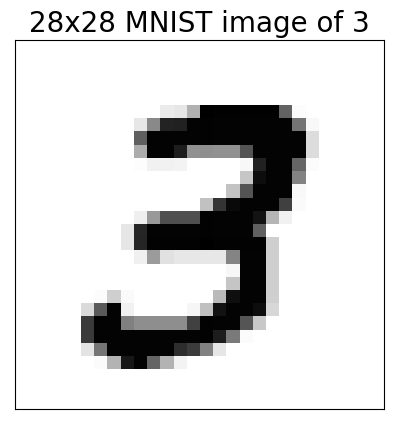

x_train_resized shape: (12049, 9, 9, 1)
x_test_resized shape: (1968, 9, 9, 1)
(12049, 9, 9, 1)


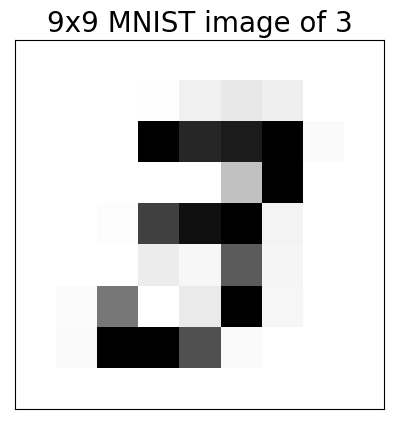

x_train_flattened shape: (12049, 81)
x_test_flattened shape: (1968, 81)
x_train_frqi_encoded shape: (12049, 162)
x_test_frqi_encoded shape: (1968, 162)
[0.11111111 0.         0.11111111 0.         0.11111111 0.
 0.11111111 0.         0.11111111 0.         0.11111111 0.
 0.11111111 0.         0.11111111 0.         0.11111111 0.
 0.11111111 0.         0.11111111 0.         0.11111111 0.
 0.11109832 0.0016857  0.10921923 0.02041665 0.1073839  0.02853729
 0.1088704  0.0222017  0.11111111 0.         0.11111111 0.
 0.11111111 0.         0.11111111 0.         0.11111111 0.
 0.00205321 0.11109214 0.02432717 0.10841526 0.01816359 0.10961644
 0.00205321 0.11109214 0.11090734 0.00672621 0.11111111 0.
 0.11111111 0.         0.11111111 0.         0.11111111 0.
 0.11111111 0.         0.11111111 0.         0.09447969 0.0584745
 0.00205321 0.11109214 0.11111111 0.         0.11111111 0.
 0.11111111 0.         0.11111111 0.         0.11102877 0.00427671
 0.03581449 0.1051808  0.01178443 0.11048442 0.002

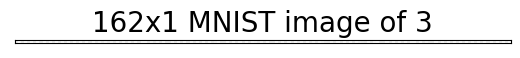

[['RZ', None, 0, [[0, 0, 0]]],
 ['RY', None, 0, [[0, 0, 1]]],
 ['RZ', None, 0, [[0, 0, 2]]],
 ['RZ', None, 1, [[0, 1, 0]]],
 ['RY', None, 1, [[0, 1, 1]]],
 ['RZ', None, 1, [[0, 1, 2]]],
 ['RZ', None, 2, [[0, 2, 0]]],
 ['RY', None, 2, [[0, 2, 1]]],
 ['RZ', None, 2, [[0, 2, 2]]],
 ['RZ', None, 3, [[0, 3, 0]]],
 ['RY', None, 3, [[0, 3, 1]]],
 ['RZ', None, 3, [[0, 3, 2]]],
 ['RZ', None, 4, [[0, 4, 0]]],
 ['RY', None, 4, [[0, 4, 1]]],
 ['RZ', None, 4, [[0, 4, 2]]],
 ['RZ', None, 5, [[0, 5, 0]]],
 ['RY', None, 5, [[0, 5, 1]]],
 ['RZ', None, 5, [[0, 5, 2]]],
 ['RZ', None, 6, [[0, 6, 0]]],
 ['RY', None, 6, [[0, 6, 1]]],
 ['RZ', None, 6, [[0, 6, 2]]],
 ['RZ', None, 7, [[0, 7, 0]]],
 ['RY', None, 7, [[0, 7, 1]]],
 ['RZ', None, 7, [[0, 7, 2]]],
 ['CNOT', 0, 1, None],
 ['CNOT', 2, 3, None],
 ['CNOT', 4, 5, None],
 ['CNOT', 6, 7, None],
 ['CNOT', 1, 2, None],
 ['CNOT', 3, 4, None],
 ['CNOT', 5, 6, None],
 ['RZ', None, 0, [[1, 0, 0]]],
 ['RY', None, 0, [[1, 0, 1]]],
 ['RZ', None, 0, [[1, 0, 2]]],
 [

ValueError: Could not interpret optimizer identifier: <pennylane.optimize.spsa.SPSAOptimizer object at 0x00000240C2E873A0>

In [106]:
# Common Experiment params
EPOCHS = 60 # Number of training epochs
BATCH_SIZE = 32 # Number of examples used in each training step
NUM_EXAMPLES = 512 # Number of examples to train on

experiments_filter = ["33"] #, "22", "23", "24"]

#------------------ Common preprocessing across experiments -------------------------

# #--------------- FILTER DIGITS -----------------
# x_train_filtered, y_train_filtered, label_mapping = filter_digits(x_train_preprocessed, y_train, digits=params["digits_to_be_filtered"])
# x_test_filtered, y_test_filtered, label_mapping = filter_digits(x_test_preprocessed, y_test, digits=params["digits_to_be_filtered"])

# print("Number of filtered training examples:", len(x_train_filtered))
# print("Number of filtered test examples:", len(x_test_filtered))
# print(pd.Series(y_train_filtered).value_counts().sort_index())
# print(label_mapping)
# y_train_final = y_train_filtered
# y_test_final = y_test_filtered
# print(y_train_final.shape, y_test_final.shape)

#----------------------------- RUN EXPERIMENTS -----------------------------------

for key, params in experiments.items():
    
    if key not in experiments_filter:
        print("Skipping experiment", key)
        continue

    print(key, params)

    #--------------- FILTER DIGITS -----------------
    x_train_filtered, y_train_filtered, label_mapping = filter_digits(x_train_norm, y_train, digits=params["digits_to_be_filtered"])
    x_test_filtered, y_test_filtered, label_mapping = filter_digits(x_test_norm, y_test, digits=params["digits_to_be_filtered"])

    print("Number of filtered training examples:", len(x_train_filtered))
    print("Number of filtered test examples:", len(x_test_filtered))
    print(pd.Series(y_train_filtered).value_counts().sort_index())
    print(label_mapping)
    x_train_final = x_train_filtered
    x_test_final = x_test_filtered
    y_train_final = y_train_filtered
    y_test_final = y_test_filtered
    print(y_train_final.shape, y_test_final.shape)
    plot_MNIST_greyscale(x_train_filtered,y_train_final,label_mapping,image_index=0)

    if params["resize_dims"]:
        #--------------- RESIZE IMAGE -----------------
        x_train_resized = resize_image(x_train_filtered, params["resize_dims"])
        x_test_resized = resize_image(x_test_filtered, params["resize_dims"])

        print("x_train_resized shape:", x_train_resized.shape)
        print("x_test_resized shape:", x_test_resized.shape)
        plot_MNIST_greyscale(x_train_resized,y_train_final,label_mapping,image_index=0)
        x_train_final = x_train_resized
        x_test_final = x_test_resized

    #--------------- SLICE IMAGE -----------------
    central_slice = 1/x_train_final.shape[1]
    if params["centre_h_slicing"]:
        slice_axis = "horizontal"
        x_train_sliced = slice_image(x_train_final, slice_axis, centre_slice=True, central_fraction=central_slice)
        x_test_sliced = slice_image(x_test_final, slice_axis, centre_slice=True, central_fraction=central_slice)

        print("x_train_sliced shape:", x_train_sliced.shape)
        print("x_test_sliced shape:", x_test_sliced.shape)
        x_train_final = x_train_sliced
        x_test_final = x_test_sliced
    else:
        #--------------- FLATTEN IMAGE -----------------
        x_train_flattened = flatten_images(x_train_final)
        x_test_flattened = flatten_images(x_test_final)

        print("x_train_flattened shape:", x_train_flattened.shape)
        print("x_test_flattened shape:", x_test_flattened.shape) 
        x_train_final = x_train_flattened
        x_test_final = x_test_flattened
    
    if params["encoding"] == "FRQI":
        x_train_frqi_encoded = frqi_encoding_all_images(x_train_final)
        print("x_train_frqi_encoded shape:", x_train_frqi_encoded.shape)
        x_test_frqi_encoded = frqi_encoding_all_images(x_test_final)
        print("x_test_frqi_encoded shape:", x_test_frqi_encoded.shape)
        x_train_final = x_train_frqi_encoded
        x_test_final = x_test_frqi_encoded

    print(x_train_final[0])

    plot_MNIST_greyscale(x_train_final,y_train_final,label_mapping,image_index=0)

    pprint(params["gate_sequence"])
    #--------------- CREATE QUANTUM ML MODEL -----------------
    model, q_node = create_quantum_model(params["n_qubits"], params["n_layers"], params["gate_sequence"], params["input_shape"], params["weight_shape"], params["encoding"], params["diff_method"])
    
    if params["encoding"] in ["amplitude", "FRQI"]:
        model.predict(x_train_final[0,:].reshape(1,-1))
    else:
        model.predict(x_train_final[0,:])
    print(model.summary())
    plot_model(model, to_file="experiments/experiment_{}/QML_model_experiment_{}.png".format(key, key), show_shapes=True, show_dtype=True, show_layer_names=True)

    #--------------- DRAW CIRCUIT -----------------
    sample_inputs = x_train_final
    sample_weights = np.random.rand(*params["weight_shape"])
    draw_quantum_circuit(q_node, params["n_qubits"],  params["n_layers"], sample_inputs, sample_weights)

    #--------------- GET HINGE LOSS LABELS -----------------
    y_train_hinge = get_hinge_labels(y_train_final)
    y_test_hinge = get_hinge_labels(y_test_final)

    #--------------- CHOOSE OPTIMISER -----------------------
    if params.get("optimiser") == "adam":
        optimiser = tf.keras.optimizers.Adam()
    elif params.get("optimiser") == "sgd":
        optimiser = tf.keras.optimizers.SGD(learning_rate=0.01)
    elif params.get("optimiser") == "rmsprop":
        optimiser = tf.keras.optimizers.RMSprop(learning_rate=0.01)
    elif params.get("optimiser") == "adagrad":
        optimiser = tf.keras.optimizers.Adagrad(learning_rate=0.01)
    elif params.get("optimiser") == "adadelta":
        optimiser = tf.keras.optimizers.Adadelta(learning_rate=0.01)
    elif params.get("optimiser") == "adamax":
        optimiser = tf.keras.optimizers.Adamax(learning_rate=0.01)
    elif params.get("optimiser") == "spsa":
        num_steps_spsa = 60
        optimiser = qml.SPSAOptimizer(maxiter=num_steps_spsa)
    else:
        optimiser = tf.keras.optimizers.Adam()

    #--------------- TRAIN QUANTUM ML MODEL -----------------
    model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=optimiser,
    metrics=[hinge_accuracy])

    x_train_sub = x_train_final[:NUM_EXAMPLES,:]
    y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]
    print(x_train_sub.shape, y_train_hinge_sub.shape)

    x_test_sub = x_test_final[:,:]
    y_test_sub = y_test_hinge[:]
    print(x_test_sub.shape, y_test_sub.shape)

    print(len(tf.config.list_physical_devices('GPU')))
    print(tf.config.list_physical_devices('GPU'))

    qnn_history = model.fit(
        x_train_sub, y_train_hinge_sub,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1,
        validation_data=(x_test_sub, y_test_sub))
    
    #--------------- SAVE TRAINING HISTORY -----------------
    experiments[key]["history"] = qnn_history.history
    
    #--------------- EVALUATE QUANTUM ML MODEL -----------------

    qnn_results = model.evaluate(x_test_sub, y_test_sub)
    print(qnn_results)

    #--------------- PRINT RESULTS -----------------
    print("Test loss:", qnn_results[0])
    print("Test accuracy:", qnn_results[1])
    
    #--------------- SAVE RESULTS -----------------
    experiments[key]["results"] = qnn_results

    #--------------- SAVE EXPERIMENTS DICT -----------------
    with open('experiments/experiment_{}/experiment_{}_out_{}.json'.format(key, key, datetime.now().strftime("%Y%m%d-%H%M%S")), 'w') as fp:
        json.dump(experiments[key], fp)
    
    with open('experiments/experiments_out_{}.json'.format(datetime.now().strftime("%Y%m%d-%H%M%S")), 'w') as fp:
        json.dump(experiments, fp)

    #--------------- PLOT TRAINING HISTORY -----------------
    plt.plot(qnn_history.history['hinge_accuracy'])
    plt.plot(qnn_history.history['val_hinge_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.savefig("experiments/experiment_{}/QML_model_experiment_{}_accuracy.png".format(key, key))
    plt.clf()

    plt.plot(qnn_history.history['loss'])
    plt.plot(qnn_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.savefig("experiments/experiment_{}/QML_model_experiment_{}_loss.png".format(key, key))
    plt.clf()

    #--------------- SAVE MODEL -----------------
    model.save("experiments/experiment_{}/QML_model_experiment_{}.h5".format(key, key))
    
    #--------------- SAVE MODEL ARCHITECTURE -----------------
    with open("experiments/experiment_{}/QML_model_experiment_{}_architecture.json".format(key, key), "w") as json_file:
        json_file.write(model.to_json())

    #--------------- SAVE MODEL WEIGHTS -----------------
    model.save_weights("experiments/experiment_{}/QML_model_experiment_{}_weights.h5".format(key, key))

    #--------------- PREDICT ON TEST SET -----------------
    y_pred = model.predict(x_test_sub)
    y_pred = np.where(y_pred > 0, 1, 0)
    if len(y_pred.shape) > 1:
        y_pred = [label_mapping[i[0]] for i in y_pred]
    else:
        y_pred = [label_mapping[i] for i in y_pred]
    y_test_sub = np.where(y_test_sub > 0, 1, 0)
    y_test_sub = [label_mapping[i] for i in y_test_sub]
    print(y_pred)
    print(y_test_sub)
    
    #--------------- CONFUSION MATRIX -----------------
    cm = confusion_matrix(y_test_sub, y_pred)
    print(cm)

    #--------------- PLOT CONFUSION MATRIX -----------------
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.savefig("experiments/experiment_{}/QML_model_experiment_{}_confusion_matrix.png".format(key, key))
    plt.show()
    plt.clf()

    #--------------- CLEAR SESSION -----------------
    tf.keras.backend.clear_session()
    

In [73]:
# #--------------- SAVE EXPERIMENTS DICT -----------------
# with open('experiments/experiment_{}/experiment_{}_out_{}.json'.format(key, key, datetime.now().strftime("%Y%m%d-%H%M%S")), 'w') as fp:
#     json.dump(experiments[key], fp)

# with open('experiments/experiments_out_{}.json'.format(datetime.now().strftime("%Y%m%d-%H%M%S")), 'w') as fp:
#     json.dump(experiments, fp)

# # #--------------- PLOT TRAINING HISTORY -----------------
# # plt.plot(qnn_history.history['hinge_accuracy'])
# # plt.plot(qnn_history.history['val_hinge_accuracy'])
# # plt.title('model accuracy')
# # plt.ylabel('accuracy')
# # plt.xlabel('epoch')
# # plt.legend(['train', 'test'], loc='lower right')
# # plt.savefig("experiments/experiment_{}/QML_model_experiment_{}_accuracy.png".format(key, key))
# # plt.clf()

# # plt.plot(qnn_history.history['loss'])
# # plt.plot(qnn_history.history['val_loss'])
# # plt.title('model loss')
# # plt.ylabel('loss')
# # plt.xlabel('epoch')
# # plt.legend(['train', 'test'], loc='lower right')
# # plt.savefig("experiments/experiment_{}/QML_model_experiment_{}_loss.png".format(key, key))
# # plt.clf()

# #--------------- SAVE MODEL -----------------
# model.save("experiments/experiment_{}/QML_model_experiment_{}.h5".format(key, key))

# #--------------- SAVE MODEL ARCHITECTURE -----------------
# with open("experiments/experiment_{}/QML_model_experiment_{}_architecture.json".format(key, key), "w") as json_file:
#     json_file.write(model.to_json())

# #--------------- SAVE MODEL WEIGHTS -----------------
# model.save_weights("experiments/experiment_{}/QML_model_experiment_{}_weights.h5".format(key, key))


In [74]:
# #--------------- PREDICT ON TEST SET -----------------
# # y_pred = model.predict(x_test_sub)
# print(y_pred)
# y_pred1 = np.where(y_pred > 0, 1, 0)
# print(label_mapping)
# print(y_pred1)
# y_pred2 = [label_mapping[i[0]] for i in y_pred1]
# print(y_pred2)
# print("----------------------")
# print(y_test_sub)
# y_test_sub = np.where(y_test_sub > 0, 1, 0)
# print(y_test_sub)
# y_test_sub = [label_mapping[i] for i in y_test_sub]
# print(y_test_sub)
# print(y_pred2)
# print(y_test_sub)

# #--------------- CONFUSION MATRIX -----------------
# cm = confusion_matrix(y_test_sub, y_pred2)
# print(cm)

# #--------------- PLOT CONFUSION MATRIX -----------------
# plt.figure(figsize=(10,10))
# sns.heatmap(cm, annot=True, fmt="d")
# plt.title("Confusion matrix")
# plt.ylabel('Actual label')
# plt.xlabel('Predicted label')
# # plt.savefig("experiments/experiment_{}/QML_model_experiment_{}_confusion_matrix.png".format(key, key))
# plt.show()
# plt.clf()


In [107]:
#------ combine all invidual experiement json into a single json file for easy analysis and comparison -------
import json
import os
import glob

multi_experiments_output = {}
experiment_key_list = []

for filename in glob.glob('experiments/experiment_*/experiment_*_out_*.json'):

    print(filename)
    #----- get folder name -------
    folder_name = filename.split(os.sep)[1]
    experiment_key = folder_name.split("_")[1]
    experiment_key_list.append(experiment_key)


    with open(filename, 'r') as fp:
        experiment = json.load(fp)
        multi_experiments_output[experiment_key] = experiment

with open('experiments/experiments_{}_out_{}.json'.format(experiment_key_list, datetime.now().strftime("%Y%m%d-%H%M%S")), 'w') as fp:
    json.dump(multi_experiments_output, fp)
multi_experiments_output

#load above multi_experiments_output json file


experiments\experiment_1\experiment_1_out_20230428-122839.json
experiments\experiment_10\experiment_10_out_20230427-205945.json
experiments\experiment_11\experiment_11_out_20230428-020136.json
experiments\experiment_12\experiment_12_out_20230428-082120.json
experiments\experiment_13\experiment_13_out_20230426-210533.json
experiments\experiment_14\experiment_14_out_20230427-011436.json
experiments\experiment_15\experiment_15_out_20230427-045900.json
experiments\experiment_16\experiment_16_out_20230427-070457.json
experiments\experiment_17\experiment_17_out_20230427-110022.json
experiments\experiment_18\experiment_18_out_20230427-174904.json
experiments\experiment_19\experiment_19_out_20230501-032212.json
experiments\experiment_2\experiment_2_out_20230428-162257.json
experiments\experiment_20\experiment_20_out_20230501-052920.json
experiments\experiment_21\experiment_21_out_20230501-211807.json
experiments\experiment_22\experiment_22_out_20230504-125315.json
experiments\experiment_22\exp

{'1': {'digits_to_be_filtered': [3, 6],
  'resize_dims': [9, 9],
  'centre_h_slicing': True,
  'n_qubits': 9,
  'n_layers': 1,
  'gate_sequence': [['RZ', None, 0, [0, 0]],
   ['RY', None, 0, [0, 1]],
   ['RZ', None, 0, [0, 2]],
   ['RZ', None, 1, [1, 0]],
   ['RY', None, 1, [1, 1]],
   ['RZ', None, 1, [1, 2]],
   ['CNOT', 1, 0, None],
   ['RZ', None, 0, [2, 0]],
   ['RY', None, 0, [2, 1]],
   ['RZ', None, 0, [2, 2]],
   ['RZ', None, 2, [3, 0]],
   ['RY', None, 2, [3, 1]],
   ['RZ', None, 2, [3, 2]],
   ['CNOT', 2, 0, None],
   ['RZ', None, 0, [4, 0]],
   ['RY', None, 0, [4, 1]],
   ['RZ', None, 0, [4, 2]],
   ['RZ', None, 3, [5, 0]],
   ['RY', None, 3, [5, 1]],
   ['RZ', None, 3, [5, 2]],
   ['CNOT', 3, 0, None],
   ['RZ', None, 0, [6, 0]],
   ['RY', None, 0, [6, 1]],
   ['RZ', None, 0, [6, 2]],
   ['RZ', None, 4, [7, 0]],
   ['RY', None, 4, [7, 1]],
   ['RZ', None, 4, [7, 2]],
   ['CNOT', 4, 0, None],
   ['RZ', None, 0, [8, 0]],
   ['RY', None, 0, [8, 1]],
   ['RZ', None, 0, [8, 2]],


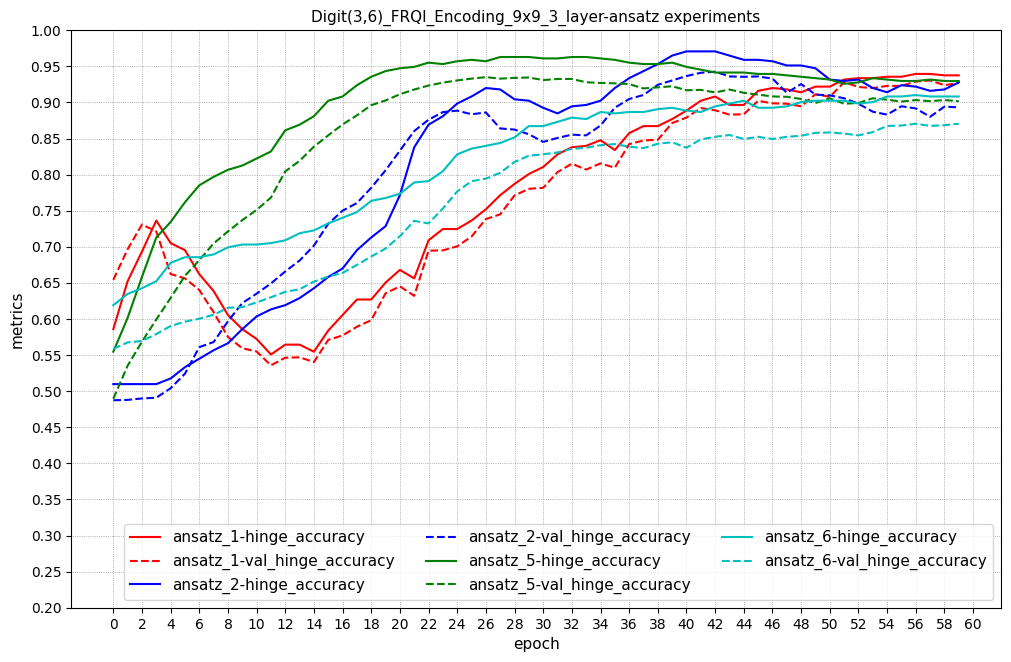

<Figure size 640x480 with 0 Axes>

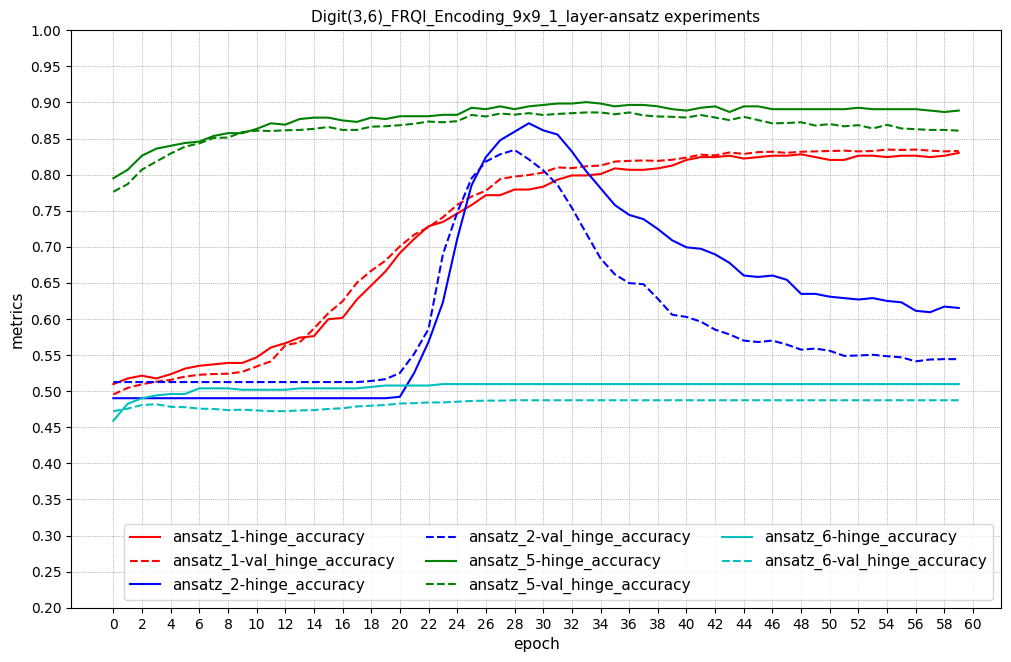

<Figure size 640x480 with 0 Axes>

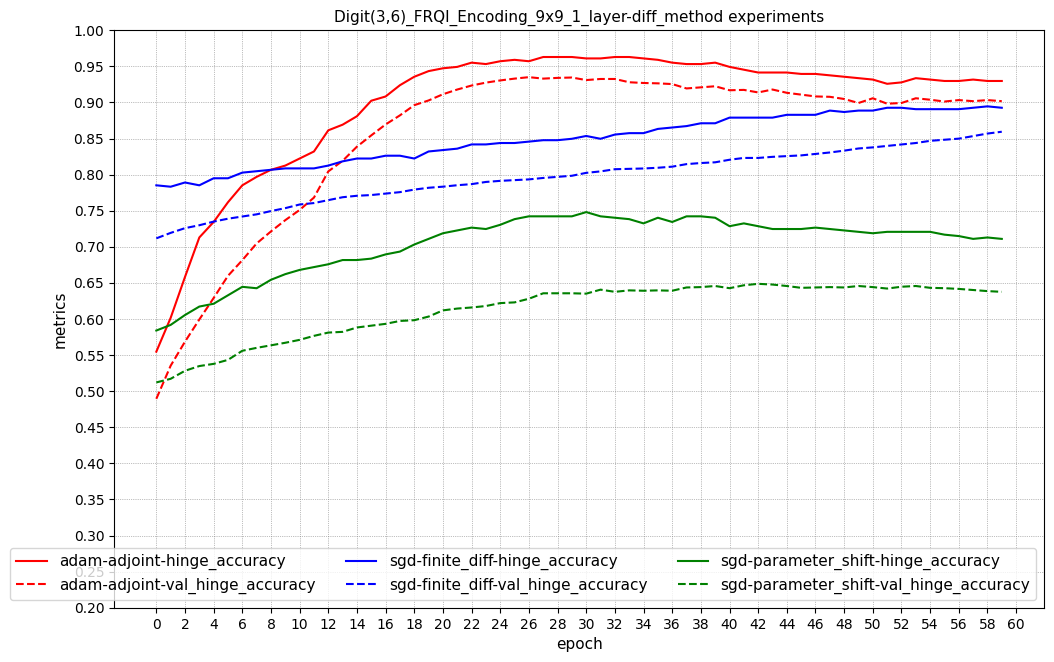

<Figure size 640x480 with 0 Axes>

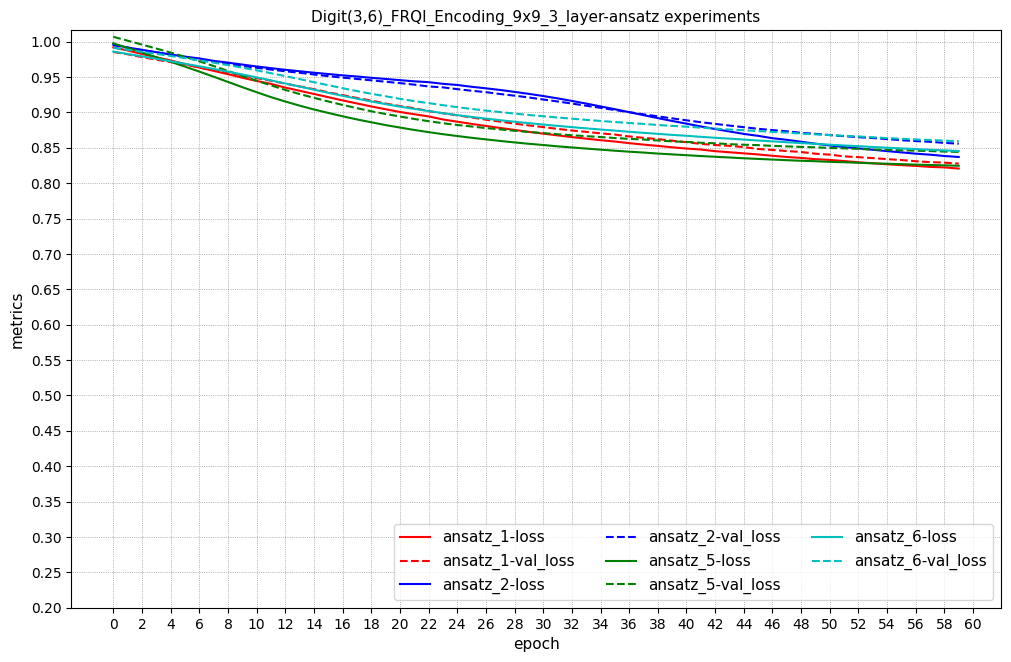

<Figure size 640x480 with 0 Axes>

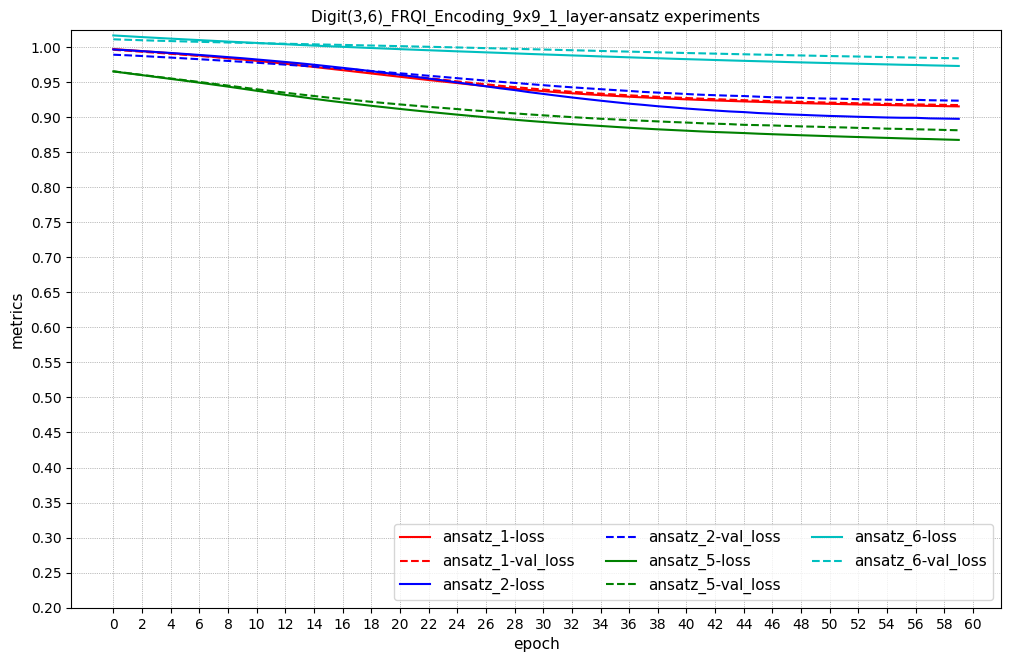

<Figure size 640x480 with 0 Axes>

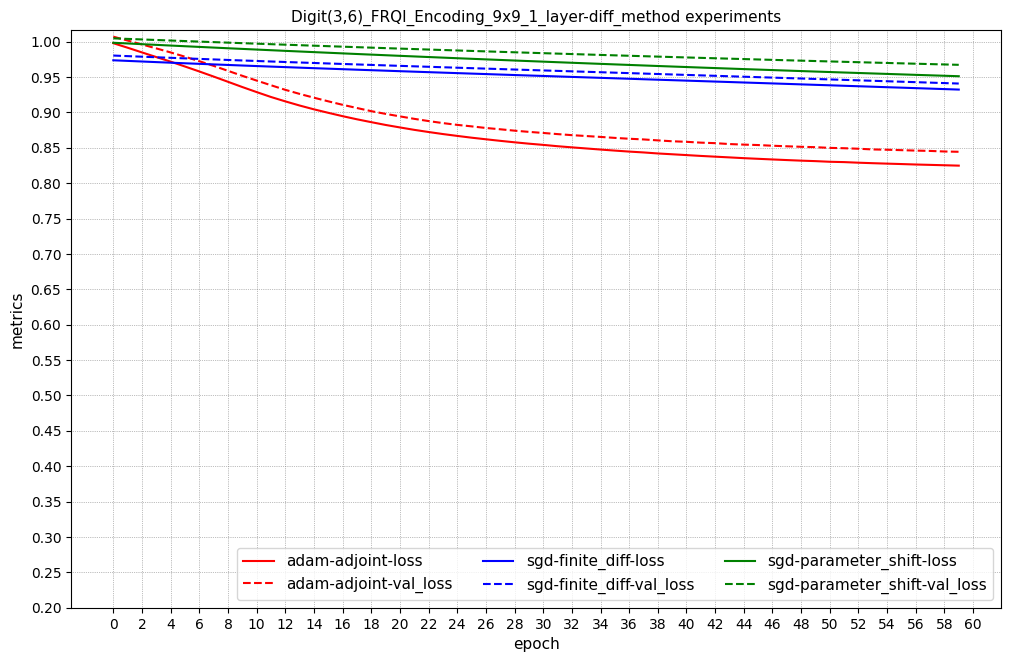

<Figure size 640x480 with 0 Axes>

In [109]:


#------- function for plotting accuracy and loss for multiple experiments together in a single plot for comparison ------------

def plot_experiment_results(experiments, metrics, title, ylabel, filename, plot_label, exp_filter):
    plt.figure(figsize=(12,7.5))
    
    #--- different experiment has different colours and train and val metrics have different line style for each experiment------

    metric_linestyle = {'hinge_accuracy':'-', 'loss':'-', 'val_hinge_accuracy':'--', 'val_loss':'--'}
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k', 'w']
    experiment_colour = {}
    i=0
    for key in experiments.keys():
        if key in exp_filter:
            experiment_colour[key] = colors[i]
            i+=1
            if isinstance(metrics, list):
                for metric in metrics:
                    plt.plot(experiments[key]["history"][metric], color=experiment_colour[key], linestyle=metric_linestyle[metric], label="{}-{}".format(plot_label[i-1], metric))
            else:
                plt.plot(experiments[key]["history"][metric], color=experiment_colour[key], linestyle=metric_linestyle[metric], label="{}-{}".format(plot_label, metric))

    plt.title(title, fontsize=11)
    plt.ylabel(ylabel, fontsize=11)
    plt.xlabel('epoch', fontsize=11)
    plt.legend(loc='lower right', ncols=3, fontsize=11)
    plt.xticks(np.arange(0, 61, 2))
    plt.yticks(np.arange(0.2, 1.05, 0.05))
    plt.grid(color = 'grey', linestyle = ':', linewidth = 0.5)
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.2, format='png', transparent=False, orientation='landscape')
    plt.show()
    plt.clf()

#----- load multi_experiments_output json file ------
with open("experiments/experiments_['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '22', '23', '24', '26', '27', '28', '29', '3', '30', '32', '4', '5', '6', '7', '8', '9']_out_20230516-092409.json", 'r') as fp:
    multi_experiments_output = json.load(fp)


history_metrics = ["hinge_accuracy", "val_hinge_accuracy", "loss", "val_loss"]
history_metrics_acc = ["hinge_accuracy", "val_hinge_accuracy"]
history_metrics_loss = ["loss", "val_loss"]
history_metrics_dict = {"accuracy":history_metrics_acc, "loss":history_metrics_loss}

for key, history_metrics in hostory_metrics_dict.items():

    # # ----------- layer comparision plots ----------------
    # #-- experiments 1,2,3 ------------
    # experiments_filter=["1","2","3"]
    # plot_title = "Digit(3,6)-Basis_Encoding-1x9_slice-9_qubits"
    # plot_label = ["1_layer", "2_layer", "3_layer"]

    # file_path = "experiments/basis_encoding_1x9_experiments_{}_{}.png".format(experiments_filter, key)
    # plot_experiment_results(multi_experiments_output, history_metrics, plot_title, "metrics", file_path, plot_label, experiments_filter)

    # #-- experiments 4,5,6 ------------
    # experiments_filter=["4","5","6"]
    # plot_title = "Digit(3,6)-Basis_Encoding-3x3_flatten-9_qubits"
    # file_path = "experiments/basis_encoding_3x3_experiments_{}_{}.png".format(experiments_filter, key)
    # plot_label = ["1_layer", "2_layer", "3_layer"]
    # plot_experiment_results(multi_experiments_output, history_metrics, plot_title, "metrics", file_path, plot_label, experiments_filter)

    # #-- experiments 7,8,9 ------------
    # experiments_filter=["7","8","9"]
    # plot_title = "Digit(3,6)-Amplitude_Encoding-9x9_flatten-7_qubits"
    # file_path = "experiments/amplitude_encoding_9x9_experiments_{}_{}.png".format(experiments_filter, key)
    # plot_label = ["1_layer", "2_layer", "3_layer"]
    # plot_experiment_results(multi_experiments_output, history_metrics, plot_title, "metrics", file_path, plot_label, experiments_filter)

    # #-- experiments 10,11,12 ------------
    # experiments_filter=["10","11","12"]
    # plot_title = "Digit(3,6)-Amplitude_Encoding-28x28_flatten-10_qubits"
    # file_path = "experiments/amplitude_encoding_28x28_experiments_{}_{}.png".format(experiments_filter, key)
    # plot_label = ["1_layer", "2_layer", "3_layer"]
    # plot_experiment_results(multi_experiments_output, history_metrics, plot_title, "metrics", file_path, plot_label, experiments_filter)

    # #-- experiments 13,14,15 ------------
    # experiments_filter=["13","14","15"]
    # plot_title = "Digit(3,6)-FRQI_Encoding-9x9_flatten-8_qubits"
    # file_path = "experiments/frqi_encoding_9x9_experiments_{}_{}.png".format(experiments_filter, key)
    # plot_label = ["1_layer", "2_layer", "3_layer"]
    # plot_experiment_results(multi_experiments_output, history_metrics, plot_title, "metrics", file_path, plot_label, experiments_filter)

    # #-- experiments 16,17,18 ------------
    # experiments_filter=["16","17","18"]
    # plot_title = "Digit(3,6)-FRQI_Encoding-28x28_flatten-10_qubits"
    # file_path = "experiments/frqi_encoding_28x28_experiments_{}_{}.png".format(experiments_filter, key)
    # plot_label = ["1_layer", "2_layer", "3_layer"]
    # plot_experiment_results(multi_experiments_output, history_metrics, plot_title, "metrics", file_path, plot_label, experiments_filter)


    # # ----------- encoding comparision plots ----------------
    # #-- experiments 1,4,7,10,13,16 ------------
    # experiments_filter=["1","4","7","10", "13", "16"]
    # plot_title = "Digit(3,6)-1_layer experiments"
    # file_path = "experiments/1_layer_experiments_{}_{}.png".format(experiments_filter, key)
    # plot_label = ["basis_1x9", "basis_3x3", "amp_9x9", "amp_28x28", "frqi_9x9", "frqi_28x28"]
    # plot_experiment_results(multi_experiments_output, history_metrics, plot_title, "metrics", file_path, plot_label, experiments_filter)

    # #-- experiments 2,5,8,11,14,17 ------------
    # experiments_filter=["2","5","8","11", "14", "17"]
    # plot_title = "Digit(3,6)-2_layer experiments"
    # file_path = "experiments/2_layer_experiments_{}_{}.png".format(experiments_filter, key)
    # plot_label = ["basis_1x9", "basis_3x3", "amp_9x9", "amp_28x28", "frqi_9x9", "frqi_28x28"]
    # plot_experiment_results(multi_experiments_output, history_metrics, plot_title, "metrics", file_path, plot_label, experiments_filter)

    # #-- experiments 3,6,9,12,15,18 ------------
    # experiments_filter=["3","6","9","12", "15", "18"]
    # plot_title = "Digit(3,6)-3_layer experiments"
    # file_path = "experiments/3_layer_experiments_{}_{}.png".format(experiments_filter, key)
    # plot_label = ["basis_1x9", "basis_3x3", "amp_9x9", "amp_28x28", "frqi_9x9", "frqi_28x28"]
    # plot_experiment_results(multi_experiments_output, history_metrics, plot_title, "metrics", file_path, plot_label, experiments_filter)

    # ----------- ansatz comparision plots ----------------
    #-- 3 layer experiments 15,19,23,24 ------------ 
    experiments_filter=["15","19","23","24"]
    plot_title = "Digit(3,6)_FRQI_Encoding_9x9_3_layer-ansatz experiments"
    file_path = "experiments/3_layer_ansatz_experiments_{}_{}.png".format(experiments_filter, key)
    plot_label = ["ansatz_1", "ansatz_2", "ansatz_5", "ansatz_6"]
    plot_experiment_results(multi_experiments_output, history_metrics, plot_title, "metrics", file_path, plot_label, experiments_filter)

    #-- 1 layer experiments 13,26,27,28 ------------
    experiments_filter=["13","26","27","28"]
    plot_title = "Digit(3,6)_FRQI_Encoding_9x9_1_layer-ansatz experiments"
    file_path = "experiments/1_layer_ansatz_experiments_{}_{}.png".format(experiments_filter, key)
    plot_label = ["ansatz_1", "ansatz_2", "ansatz_5", "ansatz_6"]
    plot_experiment_results(multi_experiments_output, history_metrics, plot_title, "metrics", file_path, plot_label, experiments_filter)

    # ----------- diff method/optimiser comparision plots ----------------
    # #-- 1 layer experiments 23,30,32 ------------
    experiments_filter=["23","30","32"]
    plot_title = "Digit(3,6)_FRQI_Encoding_9x9_1_layer-diff_method experiments"
    file_path = "experiments/diff_method_experiments_{}_{}.png".format(experiments_filter, key)
    plot_label = ["adam-adjoint", "sgd-finite_diff", "sgd-parameter_shift"]
    plot_experiment_results(multi_experiments_output, history_metrics, plot_title, "metrics", file_path, plot_label, experiments_filter)




    


In [ ]:
experiments = {}
# [3,6], 9x9, centre_h_slicing, 9 qubits, ansatz 1, basis encoding, adjoint diff
experiments["1"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":True, "n_qubits":9, "n_layers":1, "gate_sequence":gate_sequence_list[0], "input_shape":9, "encoding":"basis", "diff_method":"adjoint"}
experiments["2"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":True, "n_qubits":9, "n_layers":2, "gate_sequence":gate_sequence_list[0], "input_shape":9, "encoding":"basis", "diff_method":"adjoint"}
experiments["3"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":True, "n_qubits":9, "n_layers":3, "gate_sequence":gate_sequence_list[0], "input_shape":9, "encoding":"basis", "diff_method":"adjoint"}
# [3,6], 3x3, 9 qubits, ansatz 1, basis encoding, adjoint diff
experiments["4"] = {"digits_to_be_filtered":[3,6], "resize_dims":(3,3), "centre_h_slicing":False, "n_qubits":9, "n_layers":1, "gate_sequence":gate_sequence_list[0], "input_shape":9, "encoding":"basis", "diff_method":"adjoint"}
experiments["5"] = {"digits_to_be_filtered":[3,6], "resize_dims":(3,3), "centre_h_slicing":False, "n_qubits":9, "n_layers":2, "gate_sequence":gate_sequence_list[0], "input_shape":9, "encoding":"basis", "diff_method":"adjoint"}
experiments["6"] = {"digits_to_be_filtered":[3,6], "resize_dims":(3,3), "centre_h_slicing":False, "n_qubits":9, "n_layers":3, "gate_sequence":gate_sequence_list[0], "input_shape":9, "encoding":"basis", "diff_method":"adjoint"}
# [3,6], 9x9, 7 qubits, ansatz 2, amplitude encoding, adjoint diff
experiments["7"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":7, "n_layers":1, "gate_sequence":gate_sequence_list[1], "input_shape":81, "encoding":"amplitude", "diff_method":"adjoint"}
experiments["8"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":7, "n_layers":2, "gate_sequence":gate_sequence_list[1], "input_shape":81, "encoding":"amplitude", "diff_method":"adjoint"}
experiments["9"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":7, "n_layers":3, "gate_sequence":gate_sequence_list[1], "input_shape":81, "encoding":"amplitude", "diff_method":"adjoint"}
# [3,6], None, 10 qubits, ansatz 4, amplitude encoding, adjoint diff
experiments["10"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":10, "n_layers":1, "gate_sequence":gate_sequence_list[3], "input_shape":784, "encoding":"amplitude", "diff_method":"adjoint"}
experiments["11"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":10, "n_layers":2, "gate_sequence":gate_sequence_list[3], "input_shape":784, "encoding":"amplitude", "diff_method":"adjoint"}
experiments["12"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":10, "n_layers":3, "gate_sequence":gate_sequence_list[3], "input_shape":784, "encoding":"amplitude", "diff_method":"adjoint"}
# [3,6], 9x9, 8 qubits, ansatz 3, FRQI encoding, adjoint diff
experiments["13"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":1, "gate_sequence":gate_sequence_list[2], "input_shape":162, "encoding":"FRQI", "diff_method":"adjoint"}
experiments["14"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":2, "gate_sequence":gate_sequence_list[2], "input_shape":162, "encoding":"FRQI", "diff_method":"adjoint"}
experiments["15"] = {"digits_to_be_filtered":[3,6], "resize_dims":(9,9), "centre_h_slicing":False, "n_qubits":8, "n_layers":3, "gate_sequence":gate_sequence_list[2], "input_shape":162, "encoding":"FRQI", "diff_method":"adjoint"}
# [3,6], None, 11 qubits, ansatz 5, FRQI encoding, adjoint diff
experiments["16"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":11, "n_layers":1, "gate_sequence":gate_sequence_list[4], "input_shape":1568, "encoding":"FRQI", "diff_method":"adjoint"}
experiments["17"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":11, "n_layers":2, "gate_sequence":gate_sequence_list[4], "input_shape":1568, "encoding":"FRQI", "diff_method":"adjoint"}
experiments["18"] = {"digits_to_be_filtered":[3,6], "resize_dims":None, "centre_h_slicing":False, "n_qubits":11, "n_layers":3, "gate_sequence":gate_sequence_list[4], "input_shape":1568, "encoding":"FRQI", "diff_method":"adjoint"}


[3, 6, 3, 6, 3, 3, 3, 6, 6, 3, 3, 6, 3, 3, 3, 3, 6, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 3, 3, 6, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 3, 6, 6, 3, 3, 6, 6, 3, 3, 3, 6, 3, 6, 6, 6, 3, 3, 3, 6, 6, 3, 6, 3, 3, 3, 3, 6, 3, 3, 6, 3, 6, 6, 6, 3, 3, 3, 3, 3, 6, 3, 3, 3, 6, 3, 6, 3, 3, 6, 6, 6, 6, 6, 3, 3, 6, 3, 6, 3, 6, 6, 6, 3, 3, 3, 6, 6, 3, 6, 3, 3, 6, 3, 6, 6, 6, 6, 3, 6, 3, 6, 6, 3, 3, 6, 6, 3, 3, 3, 6, 6, 3, 3, 6, 3, 6, 6, 3, 3, 3, 3, 3, 3, 6, 6, 3, 3, 6, 3, 6, 3, 3, 3, 3, 3, 6, 6, 6, 3, 3, 6, 6, 3, 6, 3, 6, 3, 3, 6, 6, 3, 3, 3, 3, 3, 6, 6, 3, 3, 6, 3, 6, 3, 6, 6, 6, 3, 6, 6, 3, 3, 6, 6, 6, 3, 6, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 3, 3, 3, 6, 3, 3, 3, 6, 3, 6, 3, 6, 6, 6, 3, 3, 3, 3, 6, 3, 6, 3, 6, 3, 6, 6, 3, 6, 3, 3, 6, 3, 3, 3, 3, 6, 6, 3, 6, 6, 6, 3, 3, 6, 3, 6, 6, 3, 3, 3, 3, 3, 6, 3, 3, 3, 3, 6, 6, 3, 3, 6, 6, 3, 3, 3, 6, 3, 6, 3, 3, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 6, 6, 3, 3, 3, 3, 3, 6, 6, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 3, 6, 3, 3, 3, 6, 3, 6, 3, 3, 3, 6, 3, 3, 3, 3, 3, 6, 6, 3, 

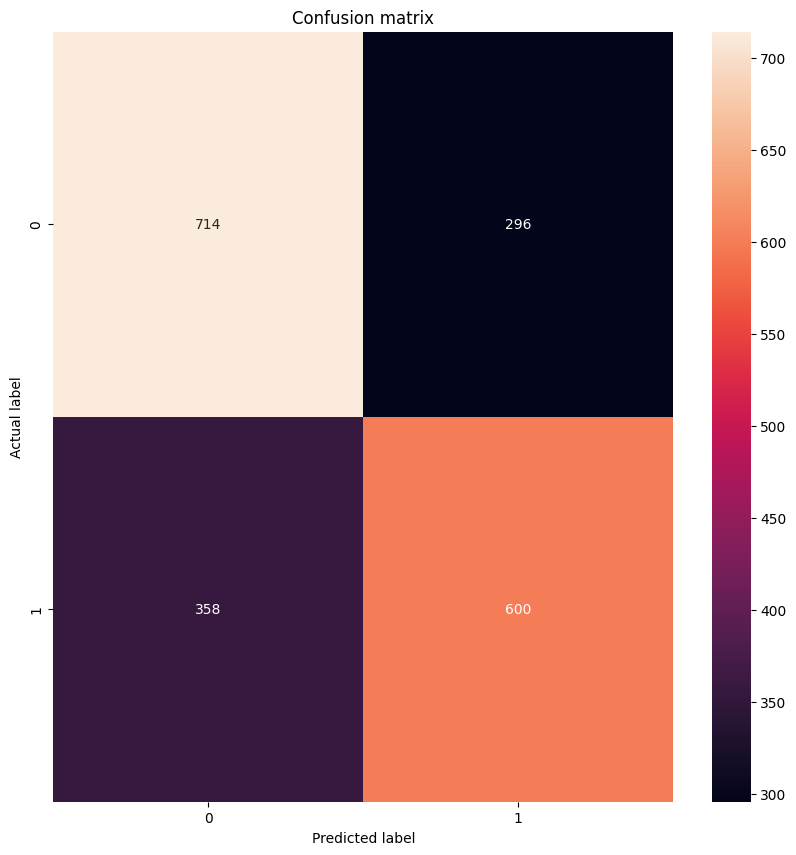

<Figure size 640x480 with 0 Axes>

In [ ]:
key = 1

print(y_pred)
print(y_test_sub)

#--------------- CONFUSION MATRIX -----------------
cm = confusion_matrix(y_test_sub, y_pred)
print(cm)

#--------------- PLOT CONFUSION MATRIX -----------------
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# plt.savefig("experiments/experiment_{}/QML_model_experiment_{}_confusion_matrix.png".format(key, key))
plt.show()
plt.clf()

In [ ]:
key=1
#--------------- LOAD MODEL -----------------
loaded_model = tf.keras.models.load_model("QML_model_experiment_{}.h5".format(key), custom_objects={"hinge_accuracy": hinge_accuracy})

#--------------- PREDICT ON TEST SET -----------------
y_pred = loaded_model.predict(x_test_sub)
y_pred = np.argmax(y_pred, axis=1)
y_pred = [label_mapping[i] for i in y_pred]
y_test_sub = [label_mapping[i] for i in y_test_sub]

#--------------- CONFUSION MATRIX -----------------
cm = confusion_matrix(y_test_sub, y_pred)
print(cm)

#--------------- PLOT CONFUSION MATRIX -----------------
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.savefig("QML_model_experiment_{}_confusion_matrix.png".format(key))
plt.clf()


ValueError: Unknown layer: KerasLayer. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
# plot the hinge accuracy for the qnn history for both 1 and 2 layer on the same axes
plt.plot(np.arange(1,21), qnn_history_1layer.history["hinge_accuracy"], label="TRAIN - 1 layer QNN")
plt.plot(np.arange(1,21), qnn_history_1layer.history["val_hinge_accuracy"], label="VAL - 1 layer QNN")
plt.plot(np.arange(1,21), qnn_history_2layer.history["hinge_accuracy"], label="TRAIN - 2 layer QNN")
plt.plot(np.arange(1,21), qnn_history_2layer.history["val_hinge_accuracy"], label="VAL - 2 layer QNN")
plt.xlabel("Epoch")
plt.ylabel("Hinge Accuracy")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("qnn_hinge_accuracy.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

In [ ]:
# plot the hinge accuracy for the loss for both 1 and 2 layer on the same axes
plt.plot(np.arange(1,21), qnn_history_1layer.history["loss"], label="TRAIN - 1 layer QNN")
plt.plot(np.arange(1,21), qnn_history_1layer.history["val_loss"], label="VAL - 1 layer QNN")
plt.plot(np.arange(1,21), qnn_history_2layer.history["loss"], label="TRAIN - 2 layer QNN")
plt.plot(np.arange(1,21), qnn_history_2layer.history["val_loss"], label="VAL - 2 layer QNN")
plt.xlabel("Epoch")
plt.ylabel("Hinge Loss")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("qnn_hinge_loss.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

In [ ]:
def plot_accuracy_and_loss(histories, layers, filename_prefix, hue_start=0, hue_end=1):
    colors = plt.cm.get_cmap('viridis', len(layers))

    for metric in ["hinge_accuracy", "loss"]:
        plt.figure()
        for i, layer in enumerate(layers):
            label_prefix = f"{layer}-layer QNN"
            color = colors(hue_start + i * (hue_end - hue_start) / (len(layers) - 1))
            
            plt.plot(np.arange(1, 21), histories[i].history[metric], label=f"TRAIN - {label_prefix}", color=color)
            plt.plot(np.arange(1, 21), histories[i].history[f"val_{metric}"], label=f"VAL - {label_prefix}", linestyle="--", color=color)

        plt.xlabel("Epoch")
        plt.ylabel("Hinge Accuracy" if metric == "hinge_accuracy" else "Hinge Loss")
        plt.legend()
        plt.xticks(np.arange(0, 21, 2.5))
        plt.savefig(f"{filename_prefix}_{metric}.pdf", bbox_inches="tight", pad_inches=0)
        plt.show()

# Example usage:
qnn_histories = [qnn_history_1layer, qnn_history_2layer]
layers = [1, 2]
plot_accuracy_and_loss(qnn_histories, layers, "qnn")